In [1]:
%load_ext autoreload
%autoreload 2
#* magic to add python path to notebook environment
import sys
pypath = sys.path[0]
%env PYTHONPATH $pypath

import numpy as np

from apps import cex_analyse, cex_toy_generator, cex_toy_parameters, cex_fit_studies
from python.analysis import cross_section, Plots, Fitting

from IPython.display import clear_output

from rich import print

cross_section.SetPlotStyle(True, dpi = 100)

def Analyse(analysis_input : cross_section.AnalysisInput, model : cross_section.pyhf.Model, args : cross_section.argparse.Namespace, energy_slices : cross_section.Slices, mean_track_score_bins : np.array, book : Plots.PlotBook = Plots.PlotBook.null):

    region_fit_result = cex_analyse.RegionFit(analysis_input, energy_slices, mean_track_score_bins, model, mc_stat_unc = args.fit["mc_stat_unc"])

    histograms_true_obs, histograms_reco_obs, histograms_reco_obs_err = cex_analyse.BackgroundSubtraction(analysis_input, args.signal_process, energy_slices, region_fit_result, book) #? make separate background subtraction function?

    unfolding_result = cex_analyse.Unfolding(histograms_reco_obs, histograms_reco_obs_err, args.toy_template, args.unfolding, args.signal_process, len(analysis_input.KE_init_reco)/len(args.toy_template.KE_init_reco), energy_slices, None, book)

    #* integrate into unfolding results
    n_incident_unfolded = cross_section.EnergySlice.NIncident(unfolding_result["init"]["unfolded"], unfolding_result["int"]["unfolded"])
    n_incident_unfolded_err = np.sqrt(unfolding_result["int"]["stat_err"]**2 + np.cumsum(unfolding_result["init"]["stat_err"]**2 + unfolding_result["int"]["stat_err"]**2))

    slice_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slices, cross_section.Particle.from_pdgid(211))
    xs = cross_section.EnergySlice.CrossSection(unfolding_result["int_ex"]["unfolded"][1:], unfolding_result["int"]["unfolded"][1:], n_incident_unfolded[1:], slice_dEdX, energy_slices.width, unfolding_result["int_ex"]["stat_err"][1:], unfolding_result["int"]["stat_err"][1:], n_incident_unfolded_err[1:])
    # Plots.plt.close("all")
    return xs


def CreateConfig(PDSP : int = 1, p_init : float = 1000, events : int = 50805, seed : int = None, verbose : bool = False, modified_PDFs : dict[np.array] = None, scale_factors : dict[float] = None, smearing : str = "double_crystal_ball", step : float = 2, beam_profile : str = "gaussian", max_cpus : int = 11):
    return {
    "events" : events,
    "step" : step,
    "p_init" : p_init,
    "beam_profile" : beam_profile,
    "beam_width" : 60,

    "smearing_params" : {
        "KE_init" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_init/{smearing}.json",
        "KE_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int/{smearing}.json",
        "z_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/z_int/{smearing}.json"
    },
    "reco_region_fractions" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5",
    "beam_selection_efficiencies" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5",
    "mean_track_score_kde" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/meanTrackScoreKDE/kdes.dill",
    "pdf_scale_factors" : scale_factors,
    "verbose" : verbose,
    "seed" : seed,
    "modified_PDFs" : modified_PDFs,
    "max_cpus" : max_cpus
    }


def SysErr(nominal, modified):
    res = np.nan_to_num(nominal - modified)

    low = res > 0 # the nominal value is higher than the modified, so the change is small
    high = ~low
    
    err_low = abs(np.where(low, res, 0))
    err_high = abs(np.where(high, res, 0))

    return err_low, err_high


env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


# Load data

In [2]:
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/cex_analysis_2GeV_config.json"))
args.toy_template = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(file = "work/2023/toys/xs_toy_2GeV_cb_2cm_template.hdf5"))
energy_overflow = np.insert(args.energy_slices.pos, 0, args.energy_slices.max_pos + args.energy_slices.width) # xlabels for KE, which has an overflow bin (max energy + energy bin width) 


In [3]:
mean_track_score_bins = np.linspace(0, 1, 21, True)
model = cross_section.RegionFit.CreateModel(args.toy_template, args.energy_slices, None, False, None, False)

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 12, 'channel_1': 12, 'channel_2': 12, 'channel_3': 12}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 0
   auxdata: []


In [4]:
toy_config_nominal = cross_section.LoadConfiguration("work/2023/toys/cex_toy_config_2GeV.json")
toy_config_nominal["seed"] = 1
toy_config_nominal["max_cpus"] = 6
toy_config_nominal["events"] = int(1E5)

In [5]:
# toy_nominal = cross_section.Toy(
#     df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(2, 2000, int(1E6),
#     seed = 1,
#     smearing = "double_crystal_ball",
#     step = 2,
#     beam_profile = "work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/beam_profile/beam_profile.json",
#     max_cpus = 6
#     ))))
toy_nominal = cross_section.Toy(df = cex_toy_generator.run(toy_config_nominal))

starting batch : 0, cpus : 6

starting batch : 1, cpus : 4

Simulating |████████████████████████████████████████| 2/2 [100%] in 6.2s (0.32/s) 


Done! Creating dataframe...

total_inelastic 99991

decay 9

charge_exchange 9578

pion_production 47181

quasielastic 31109

absorption 6850

double_charge_exchange 5273

9

'BeamSelectionEfficiency' executed in 0.0405s

'GenerateRecoRegions' executed in 0.1442s

'MeanTrackScore' executed in 0.4873s

'main' executed in 7.3379s

In [6]:
analysis_input_nominal = cross_section.AnalysisInput.CreateAnalysisInputToy(toy_nominal)
xs_nominal = Analyse(analysis_input_nominal, model, args, args.energy_slices, None, None)

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-9439351.4774171])


signal: charge_exchange

Iteration 1: ts = 0.0017, ts_stopping = 0.001
Iteration 2: ts = 0.0006, ts_stopping = 0.001
Iteration 1: ts = 0.0006, ts_stopping = 0.001
Iteration 1: ts = 0.0087, ts_stopping = 0.001
Iteration 2: ts = 0.0060, ts_stopping = 0.001
Iteration 3: ts = 0.0054, ts_stopping = 0.001
Iteration 4: ts = 0.0050, ts_stopping = 0.001
Iteration 5: ts = 0.0045, ts_stopping = 0.001
Iteration 6: ts = 0.0040, ts_stopping = 0.001


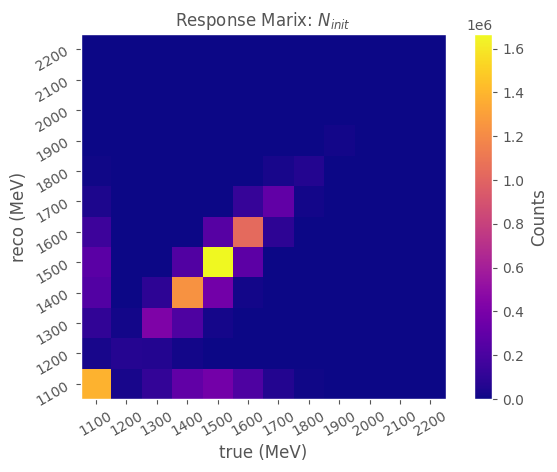

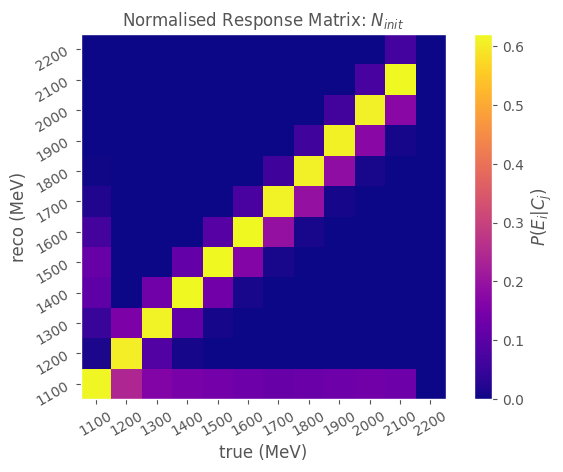

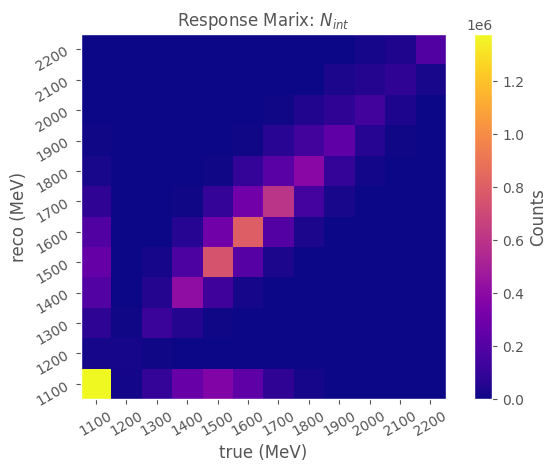

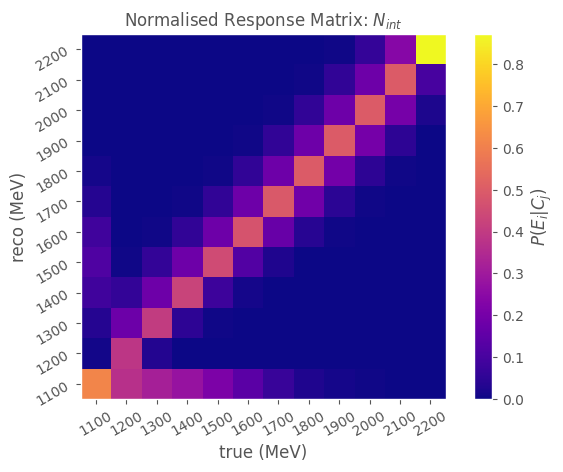

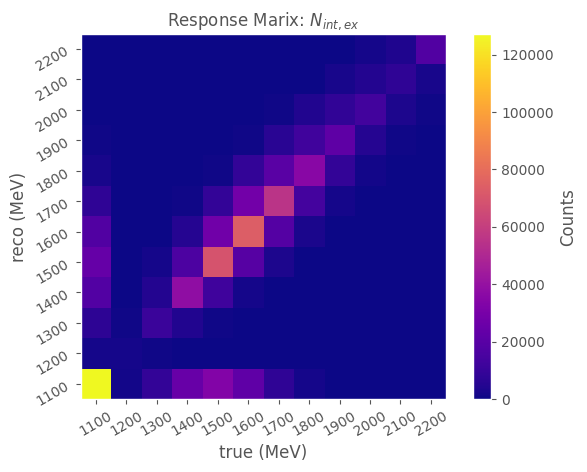

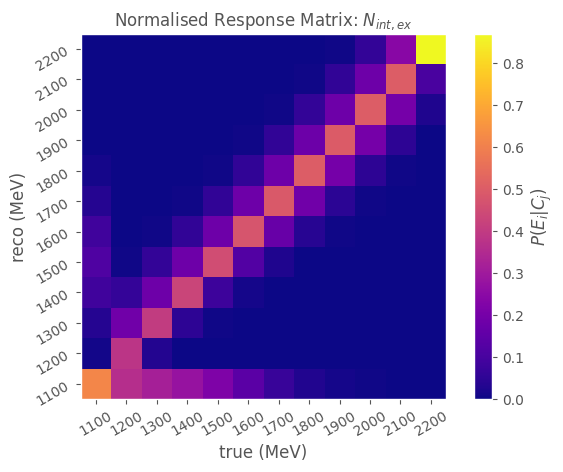

In [52]:
m = cross_section.Unfold.CalculateResponseMatrices(args.toy_template, args.signal_process, args.energy_slices, Plots.PlotBook.null)

# MC Stat uncertainty

In [16]:
def PseudoExperiment(n_experiments, n_data, n_template):
    data_config = {k : v for k, v in toy_config_nominal.items()}
    data_config["seed"] = None
    data_config["events"] = n_data

    template_config = {k : v for k, v in toy_config_nominal.items()}
    template_config["seed"] = None
    template_config["events"] = n_template

    xs = []
    for i in range(n_experiments):
        print(f"{i=}")
        ai_template = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.run(template_config)))
        ai_data = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.run(data_config)))
        xs.append(Analyse(ai_data, ai_template, args, args.energy_slices, None, None))
        clear_output()        

    return np.array(xs)

n_experiments = 101
n_data = 72780
n_template = 29452

xs = PseudoExperiment(n_experiments, n_data, n_template)

In [33]:
cross_section.SaveObject("test/mc_stat_results.dill", xs)

[ 197.55162786   44.48241306   23.86933826   13.75573954   11.01124382
   11.0247282    11.37993186   15.63823666   18.54181752   23.8417464
   31.20114062   41.7196889    44.78570444 2252.82976052]

[ 165.31481988   49.5700049    41.69310365   45.94448584   50.52706997
   54.3725391    59.37011065   63.19353946   70.26495323   74.90966112
   86.46898951   90.01963669   87.43404877 4735.94521514]

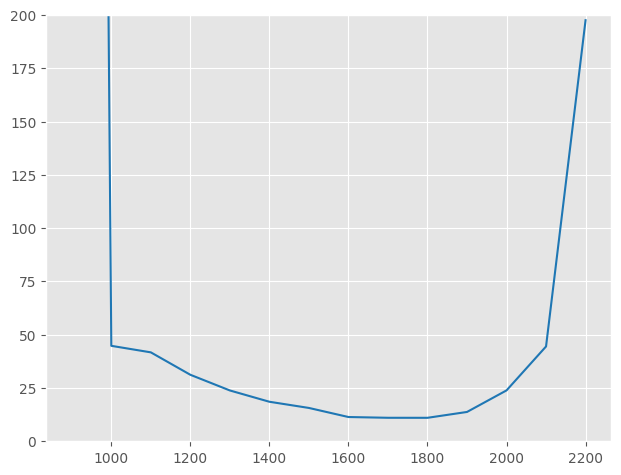

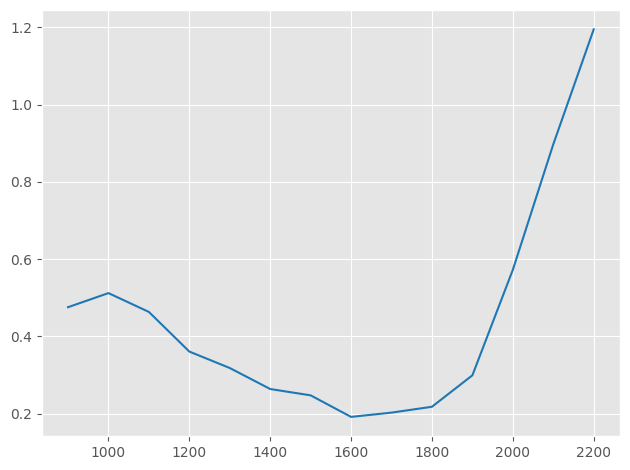

In [27]:
# cv = xs[0][0]
cv = np.nanmean(xs[:, 0], 0)
res = xs[:, 0] - cv

mean = np.nanmean(abs(res), 0)
print(mean)
print(cv)
Plots.Plot(args.energy_slices.pos, mean)
Plots.plt.ylim(0, 200)

Plots.Plot(args.energy_slices.pos, mean/cv)

# Region fit normalisation systematic

## with unfolding

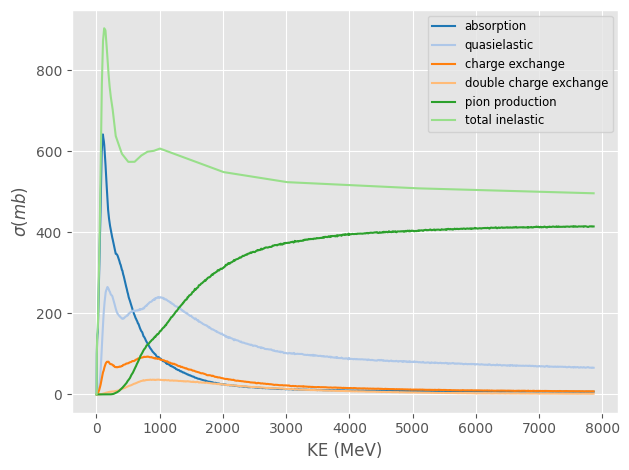

In [39]:
xs = cex_toy_generator.ModifyGeantXS(scale_factors = {"absorption" : 1, "charge_exchange" : 1, "pion_production" : 1, "double_charge_exchange" : 1, "quasielastic" : 1}, modified_PDFs = None)
xs.Plot("all")

In [72]:
def NormalisationSystematic(data_config : dict, norms = [0.8, 1.2]):
    x = args.energy_slices.pos - args.energy_slices.width/2
    # x = args.energy_slices.pos# + args.energy_slices.width/2

    exclusive_proc = ["absorption", "charge_exchange", "single_pion_production", "pion_production"]
    cvs = {}
    true_cvs = {}
    for target in exclusive_proc:
        print(f"{target=}")
        # scales = {k : 1 for k in exclusive_proc}
        scales = {k : 1 for k in ['absorption', 'quasielastic', 'charge_exchange', 'double_charge_exchange', 'pion_production']}
        xs = {}
        xs_true = {}
        for i in norms:
            if i == 1:
                config = {k : v for k,v in data_config.items()}
            else:
                if target == "single_pion_production":
                    scales["quasielastic"] = i
                    scales["double_charge_exchange"] = i
                else:
                    scales[target] = i
                config = cex_fit_studies.CreateConfigNormalisation(scales, data_config)
            ai = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.run(config)))
            xs[i] = Analyse(ai, model, args, args.energy_slices, None, None)
            xs_sim_mod = cex_toy_generator.ModifyGeantXS(scale_factors = config["pdf_scale_factors"])
            xs_true[i] = xs_sim_mod.GetInterpolatedCurve(args.signal_process)(x)
        cvs[target] = xs
        true_cvs[target] = xs_true
    return cvs, true_cvs
results = NormalisationSystematic(toy_config_nominal, [0.8, 1.2])

target='absorption'

starting batch : 0, cpus : 6

starting batch : 1, cpus : 4

Simulating |████████████████████████████████████████| 2/2 [100%] in 6.6s (0.30/s) 


Done! Creating dataframe...

total_inelastic 99991

decay 9

quasielastic 31833

pion_production 47805

double_charge_exchange 5263

charge_exchange 9392

absorption 5698

9

'BeamSelectionEfficiency' executed in 0.0081s

'GenerateRecoRegions' executed in 0.1264s

'MeanTrackScore' executed in 0.4610s

'main' executed in 7.5582s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-9439396.09834363])


signal: charge_exchange

Iteration 1: ts = 0.0017, ts_stopping = 0.0001
Iteration 2: ts = 0.0006, ts_stopping = 0.0001
Iteration 3: ts = 0.0005, ts_stopping = 0.0001
Iteration 4: ts = 0.0004, ts_stopping = 0.0001
Iteration 5: ts = 0.0003, ts_stopping = 0.0001
Iteration 6: ts = 0.0003, ts_stopping = 0.0001
Iteration 1: ts = 0.0006, ts_stopping = 0.0001
Iteration 2: ts = 0.0005, ts_stopping = 0.0001
Iteration 3: ts = 0.0005, ts_stopping = 0.0001
Iteration 4: ts = 0.0004, ts_stopping = 0.0001
Iteration 5: ts = 0.0004, ts_stopping = 0.0001
Iteration 6: ts = 0.0004, ts_stopping = 0.0001
Iteration 1: ts = 0.0108, ts_stopping = 0.0001
Iteration 2: ts = 0.0057, ts_stopping = 0.0001
Iteration 3: ts = 0.0053, ts_stopping = 0.0001
Iteration 4: ts = 0.0050, ts_stopping = 0.0001
Iteration 5: ts = 0.0046, ts_stopping = 0.0001
Iteration 6: ts = 0.0041, ts_stopping = 0.0001


starting batch : 0, cpus : 6

starting batch : 1, cpus : 4

Simulating |████████████████████████████████████████| 2/2 [100%] in 6.4s (0.31/s) 


Done! Creating dataframe...

total_inelastic 99991

decay 9

quasielastic 30913

pion_production 46523

charge_exchange 9097

absorption 8286

double_charge_exchange 5172

9

'BeamSelectionEfficiency' executed in 0.0087s

'GenerateRecoRegions' executed in 0.1396s

'MeanTrackScore' executed in 0.4734s

'main' executed in 7.4039s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-9439393.63546634])


signal: charge_exchange

Iteration 1: ts = 0.0017, ts_stopping = 0.0001
Iteration 2: ts = 0.0006, ts_stopping = 0.0001
Iteration 3: ts = 0.0005, ts_stopping = 0.0001
Iteration 4: ts = 0.0004, ts_stopping = 0.0001
Iteration 5: ts = 0.0003, ts_stopping = 0.0001
Iteration 6: ts = 0.0003, ts_stopping = 0.0001
Iteration 1: ts = 0.0006, ts_stopping = 0.0001
Iteration 2: ts = 0.0005, ts_stopping = 0.0001
Iteration 3: ts = 0.0005, ts_stopping = 0.0001
Iteration 4: ts = 0.0004, ts_stopping = 0.0001
Iteration 5: ts = 0.0004, ts_stopping = 0.0001
Iteration 6: ts = 0.0004, ts_stopping = 0.0001
Iteration 1: ts = 0.0093, ts_stopping = 0.0001
Iteration 2: ts = 0.0047, ts_stopping = 0.0001
Iteration 3: ts = 0.0048, ts_stopping = 0.0001
Iteration 4: ts = 0.0047, ts_stopping = 0.0001
Iteration 5: ts = 0.0044, ts_stopping = 0.0001
Iteration 6: ts = 0.0040, ts_stopping = 0.0001


target='charge_exchange'

starting batch : 0, cpus : 6

starting batch : 1, cpus : 4

Simulating |████████████████████████████████████████| 2/2 [100%] in 7.5s (0.27/s) 


Done! Creating dataframe...

total_inelastic 99991

decay 9

quasielastic 31966

pion_production 48045

double_charge_exchange 5283

charge_exchange 7546

absorption 7151

9

'BeamSelectionEfficiency' executed in 0.0092s

'GenerateRecoRegions' executed in 0.1598s

'MeanTrackScore' executed in 0.5079s

'main' executed in 8.6298s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-9439405.3045604])


signal: charge_exchange

Iteration 1: ts = 0.0017, ts_stopping = 0.0001
Iteration 2: ts = 0.0006, ts_stopping = 0.0001
Iteration 3: ts = 0.0005, ts_stopping = 0.0001
Iteration 4: ts = 0.0004, ts_stopping = 0.0001
Iteration 5: ts = 0.0003, ts_stopping = 0.0001
Iteration 6: ts = 0.0003, ts_stopping = 0.0001
Iteration 1: ts = 0.0006, ts_stopping = 0.0001
Iteration 2: ts = 0.0005, ts_stopping = 0.0001
Iteration 3: ts = 0.0005, ts_stopping = 0.0001
Iteration 4: ts = 0.0004, ts_stopping = 0.0001
Iteration 5: ts = 0.0004, ts_stopping = 0.0001
Iteration 6: ts = 0.0004, ts_stopping = 0.0001
Iteration 1: ts = 0.0116, ts_stopping = 0.0001
Iteration 2: ts = 0.0069, ts_stopping = 0.0001
Iteration 3: ts = 0.0064, ts_stopping = 0.0001
Iteration 4: ts = 0.0061, ts_stopping = 0.0001
Iteration 5: ts = 0.0056, ts_stopping = 0.0001
Iteration 6: ts = 0.0050, ts_stopping = 0.0001


starting batch : 0, cpus : 6

starting batch : 1, cpus : 4

Simulating |████████████████████████████████████████| 2/2 [100%] in 6.8s (0.29/s) 


Done! Creating dataframe...

total_inelastic 99991

decay 9

quasielastic 30790

pion_production 46270

charge_exchange 10932

double_charge_exchange 5134

absorption 6865

9

'BeamSelectionEfficiency' executed in 0.0101s

'GenerateRecoRegions' executed in 0.1485s

'MeanTrackScore' executed in 0.4902s

'main' executed in 7.8468s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-9439401.78632362])


signal: charge_exchange

Iteration 1: ts = 0.0017, ts_stopping = 0.0001
Iteration 2: ts = 0.0006, ts_stopping = 0.0001
Iteration 3: ts = 0.0005, ts_stopping = 0.0001
Iteration 4: ts = 0.0004, ts_stopping = 0.0001
Iteration 5: ts = 0.0003, ts_stopping = 0.0001
Iteration 6: ts = 0.0003, ts_stopping = 0.0001
Iteration 1: ts = 0.0006, ts_stopping = 0.0001
Iteration 2: ts = 0.0005, ts_stopping = 0.0001
Iteration 3: ts = 0.0005, ts_stopping = 0.0001
Iteration 4: ts = 0.0004, ts_stopping = 0.0001
Iteration 5: ts = 0.0004, ts_stopping = 0.0001
Iteration 6: ts = 0.0004, ts_stopping = 0.0001
Iteration 1: ts = 0.0080, ts_stopping = 0.0001
Iteration 2: ts = 0.0041, ts_stopping = 0.0001
Iteration 3: ts = 0.0041, ts_stopping = 0.0001
Iteration 4: ts = 0.0040, ts_stopping = 0.0001
Iteration 5: ts = 0.0038, ts_stopping = 0.0001
Iteration 6: ts = 0.0035, ts_stopping = 0.0001


target='single_pion_production'

starting batch : 0, cpus : 6

starting batch : 1, cpus : 4

Simulating |████████████████████████████████████████| 2/2 [100%] in 7.1s (0.28/s) 


Done! Creating dataframe...

total_inelastic 99991

decay 9

quasielastic 27049

pion_production 50834

charge_exchange 10075

double_charge_exchange 4459

absorption 7574

9

'BeamSelectionEfficiency' executed in 0.0098s

'GenerateRecoRegions' executed in 0.1688s

'MeanTrackScore' executed in 0.6112s

'main' executed in 8.3764s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-9439396.40695982])


signal: charge_exchange

Iteration 1: ts = 0.0017, ts_stopping = 0.0001
Iteration 2: ts = 0.0006, ts_stopping = 0.0001
Iteration 3: ts = 0.0005, ts_stopping = 0.0001
Iteration 4: ts = 0.0004, ts_stopping = 0.0001
Iteration 5: ts = 0.0003, ts_stopping = 0.0001
Iteration 6: ts = 0.0003, ts_stopping = 0.0001
Iteration 1: ts = 0.0006, ts_stopping = 0.0001
Iteration 2: ts = 0.0005, ts_stopping = 0.0001
Iteration 3: ts = 0.0005, ts_stopping = 0.0001
Iteration 4: ts = 0.0004, ts_stopping = 0.0001
Iteration 5: ts = 0.0004, ts_stopping = 0.0001
Iteration 6: ts = 0.0004, ts_stopping = 0.0001
Iteration 1: ts = 0.0152, ts_stopping = 0.0001
Iteration 2: ts = 0.0065, ts_stopping = 0.0001
Iteration 3: ts = 0.0055, ts_stopping = 0.0001
Iteration 4: ts = 0.0049, ts_stopping = 0.0001
Iteration 5: ts = 0.0045, ts_stopping = 0.0001
Iteration 6: ts = 0.0040, ts_stopping = 0.0001


starting batch : 0, cpus : 6

starting batch : 1, cpus : 4

Simulating |████████████████████████████████████████| 2/2 [100%] in 8.0s (0.25/s) 


Done! Creating dataframe...

total_inelastic 99991

decay 9

quasielastic 35032

pion_production 43914

charge_exchange 8728

double_charge_exchange 5806

absorption 6511

9

'BeamSelectionEfficiency' executed in 0.0102s

'GenerateRecoRegions' executed in 0.1704s

'MeanTrackScore' executed in 0.5246s

'main' executed in 9.1760s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-9439403.67365873])


signal: charge_exchange

Iteration 1: ts = 0.0017, ts_stopping = 0.0001
Iteration 2: ts = 0.0006, ts_stopping = 0.0001
Iteration 3: ts = 0.0005, ts_stopping = 0.0001
Iteration 4: ts = 0.0004, ts_stopping = 0.0001
Iteration 5: ts = 0.0003, ts_stopping = 0.0001
Iteration 6: ts = 0.0003, ts_stopping = 0.0001
Iteration 1: ts = 0.0006, ts_stopping = 0.0001
Iteration 2: ts = 0.0005, ts_stopping = 0.0001
Iteration 3: ts = 0.0005, ts_stopping = 0.0001
Iteration 4: ts = 0.0004, ts_stopping = 0.0001
Iteration 5: ts = 0.0004, ts_stopping = 0.0001
Iteration 6: ts = 0.0004, ts_stopping = 0.0001
Iteration 1: ts = 0.0140, ts_stopping = 0.0001
Iteration 2: ts = 0.0064, ts_stopping = 0.0001
Iteration 3: ts = 0.0050, ts_stopping = 0.0001
Iteration 4: ts = 0.0050, ts_stopping = 0.0001
Iteration 5: ts = 0.0047, ts_stopping = 0.0001
Iteration 6: ts = 0.0043, ts_stopping = 0.0001


target='pion_production'

starting batch : 0, cpus : 6

starting batch : 1, cpus : 4

Simulating |████████████████████████████████████████| 2/2 [100%] in 6.8s (0.29/s) 


Done! Creating dataframe...

total_inelastic 99991

decay 9

quasielastic 34573

pion_production 41609

charge_exchange 10261

absorption 7697

double_charge_exchange 5851

9

'BeamSelectionEfficiency' executed in 0.0094s

'GenerateRecoRegions' executed in 0.1508s

'MeanTrackScore' executed in 0.4954s

'main' executed in 7.8667s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-9439410.20326273])


signal: charge_exchange

Iteration 1: ts = 0.0017, ts_stopping = 0.0001
Iteration 2: ts = 0.0006, ts_stopping = 0.0001
Iteration 3: ts = 0.0005, ts_stopping = 0.0001
Iteration 4: ts = 0.0004, ts_stopping = 0.0001
Iteration 5: ts = 0.0003, ts_stopping = 0.0001
Iteration 6: ts = 0.0003, ts_stopping = 0.0001
Iteration 1: ts = 0.0006, ts_stopping = 0.0001
Iteration 2: ts = 0.0005, ts_stopping = 0.0001
Iteration 3: ts = 0.0005, ts_stopping = 0.0001
Iteration 4: ts = 0.0004, ts_stopping = 0.0001
Iteration 5: ts = 0.0004, ts_stopping = 0.0001
Iteration 6: ts = 0.0004, ts_stopping = 0.0001
Iteration 1: ts = 0.0240, ts_stopping = 0.0001
Iteration 2: ts = 0.0076, ts_stopping = 0.0001
Iteration 3: ts = 0.0039, ts_stopping = 0.0001
Iteration 4: ts = 0.0037, ts_stopping = 0.0001
Iteration 5: ts = 0.0036, ts_stopping = 0.0001
Iteration 6: ts = 0.0034, ts_stopping = 0.0001


starting batch : 0, cpus : 6

starting batch : 1, cpus : 4

Simulating |████████████████████████████████████████| 2/2 [100%] in 7.8s (0.26/s) 


Done! Creating dataframe...

total_inelastic 99991

decay 9

quasielastic 28661

pion_production 51700

charge_exchange 8583

double_charge_exchange 4636

absorption 6411

9

'BeamSelectionEfficiency' executed in 0.0134s

'GenerateRecoRegions' executed in 0.1808s

'MeanTrackScore' executed in 0.7182s

'main' executed in 9.2265s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-9439402.95840164])


signal: charge_exchange

Iteration 1: ts = 0.0017, ts_stopping = 0.0001
Iteration 2: ts = 0.0006, ts_stopping = 0.0001
Iteration 3: ts = 0.0005, ts_stopping = 0.0001
Iteration 4: ts = 0.0004, ts_stopping = 0.0001
Iteration 5: ts = 0.0003, ts_stopping = 0.0001
Iteration 6: ts = 0.0003, ts_stopping = 0.0001
Iteration 1: ts = 0.0006, ts_stopping = 0.0001
Iteration 2: ts = 0.0005, ts_stopping = 0.0001
Iteration 3: ts = 0.0005, ts_stopping = 0.0001
Iteration 4: ts = 0.0004, ts_stopping = 0.0001
Iteration 5: ts = 0.0004, ts_stopping = 0.0001
Iteration 6: ts = 0.0004, ts_stopping = 0.0001
Iteration 1: ts = 0.0303, ts_stopping = 0.0001
Iteration 2: ts = 0.0092, ts_stopping = 0.0001
Iteration 3: ts = 0.0071, ts_stopping = 0.0001
Iteration 4: ts = 0.0062, ts_stopping = 0.0001
Iteration 5: ts = 0.0056, ts_stopping = 0.0001
Iteration 6: ts = 0.0049, ts_stopping = 0.0001


In [73]:
book = Plots.PlotBook("normalisation_sys.pdf", False)

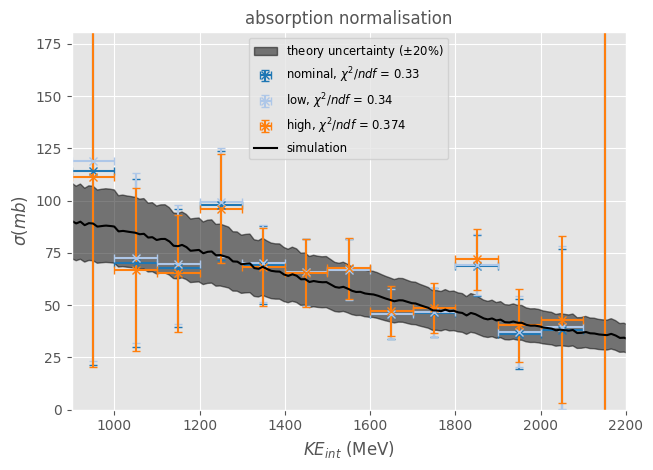

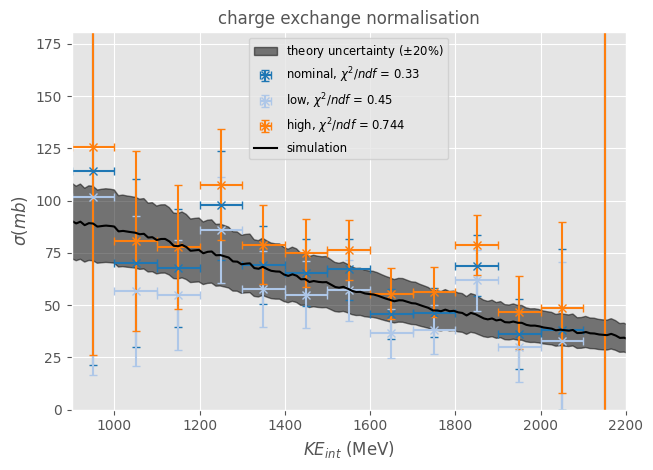

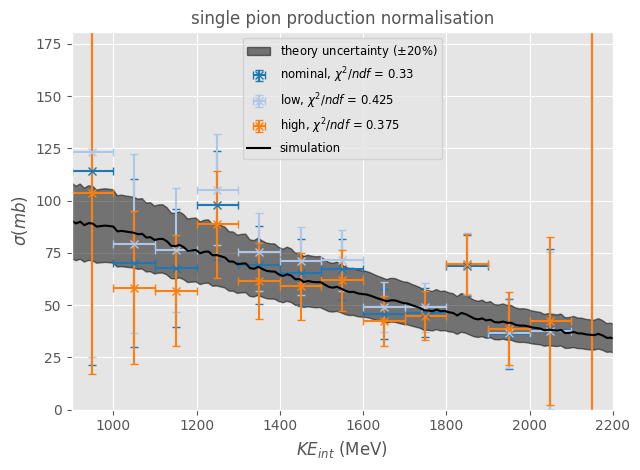

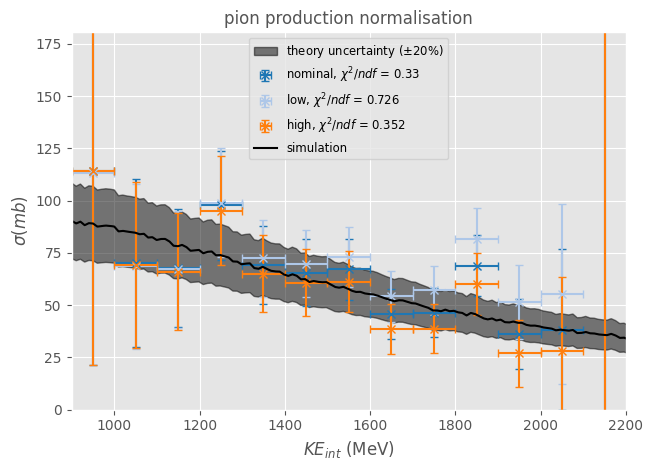

In [74]:
xs_sim = cross_section.GeantCrossSections()
for r in results[0]:
    cross_section.PlotXSComparison({"nominal" : xs_nominal, "low" : results[0][r][0.8], "high" : results[0][r][1.2]}, args.energy_slices, args.signal_process, title = f"{cross_section.remove_(r)} normalisation")
    Plots.plt.fill_between(xs_sim.KE, getattr(xs_sim, args.signal_process) * 0.8, getattr(xs_sim, args.signal_process) * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
    Plots.plt.legend()
    book.Save()

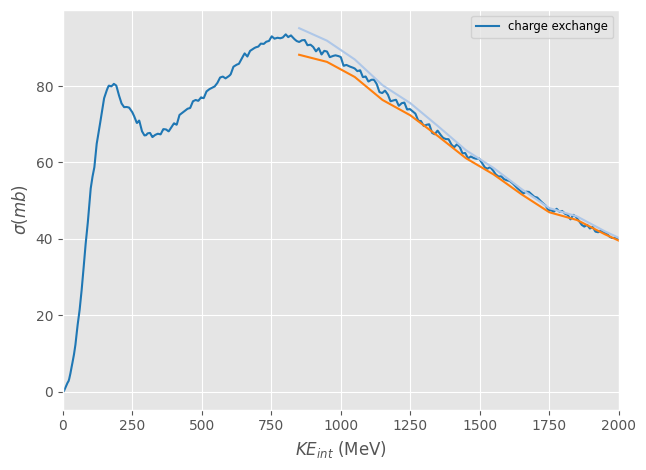

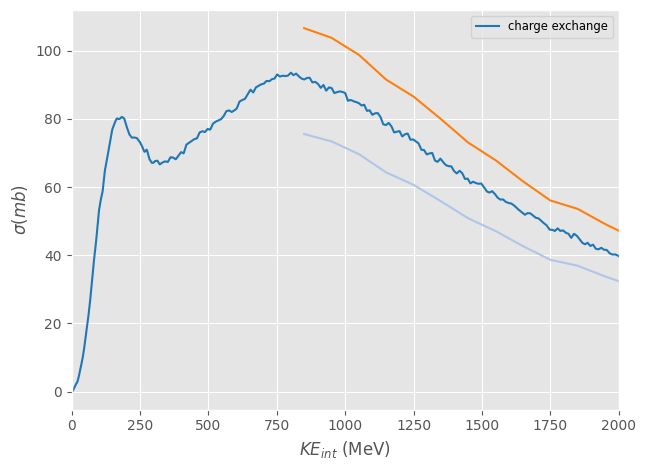

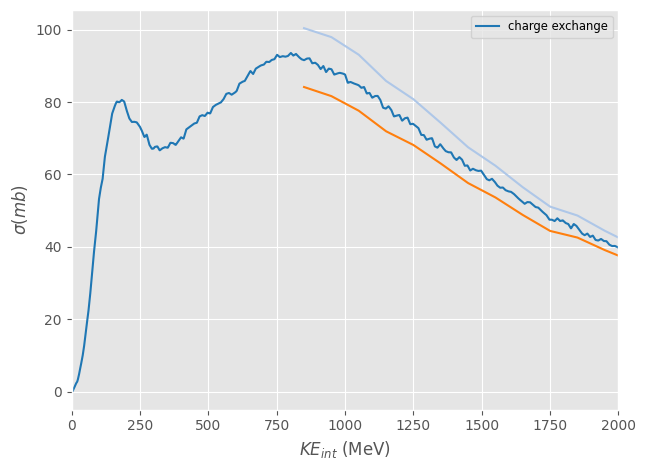

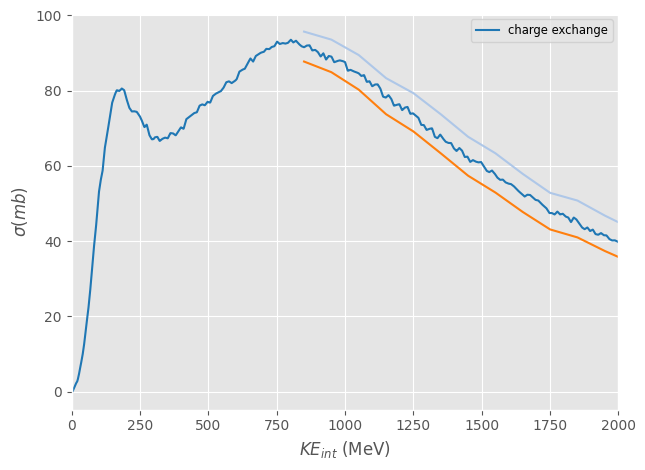

In [77]:
for r in results[1]:
    Plots.plt.figure()
    xs_sim.Plot("charge_exchange")
    Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, results[1][r][0.8], newFigure = False)
    Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, results[1][r][1.2], newFigure = False)
    Plots.plt.xlim(0, 2000)
    # cross_section.PlotXSComparison({"low" : results[1][r][0.8], "high" : results[1][r][1.2]}, args.energy_slices, args.signal_process, title = f"{cross_section.remove_(r)} normalisation")


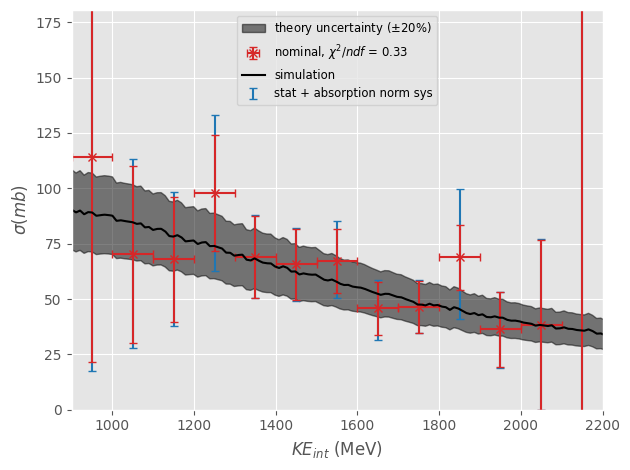

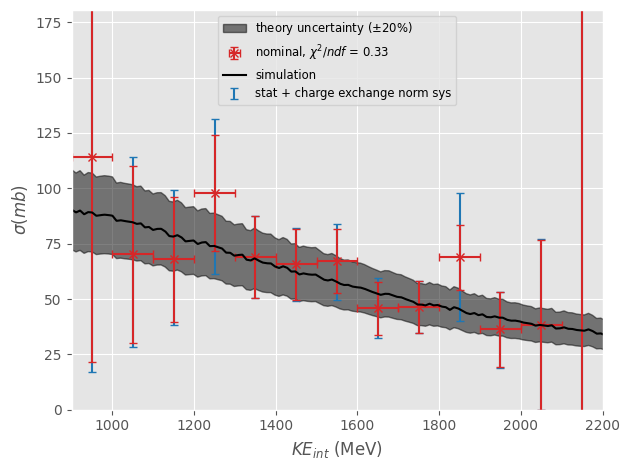

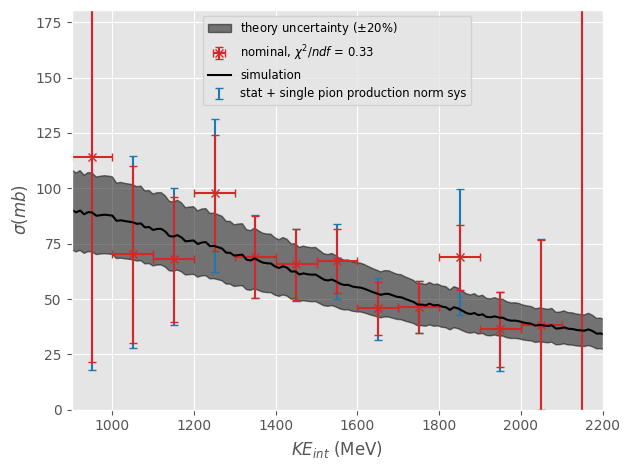

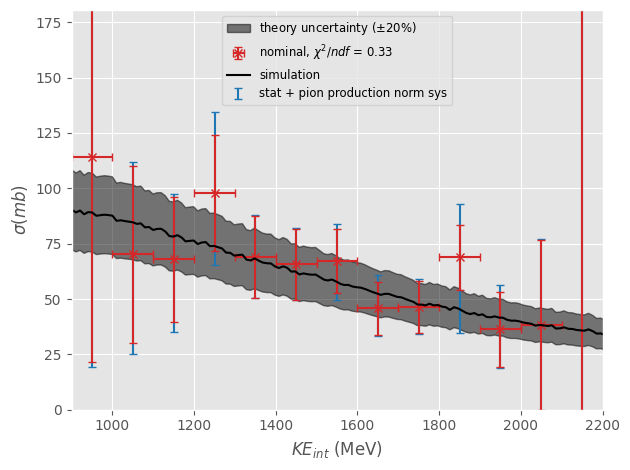

In [83]:
for r in results[0]:
    # err_low = SysErr(results[1][r][1.2], results[0][r][1.2][0])
    # err_high = SysErr(results[1][r][0.8], results[0][r][0.8][0])

    # sys_err_low = np.max([err_low[0], err_high[0]], 0)
    # sys_err_high = np.max([err_low[1], err_high[1]], 0)

    sys_err_low = results[0][r][0.8][0] - results[1][r][0.8]
    sys_err_high = results[0][r][1.2][0] - results[1][r][1.2]

    total_err_low = cross_section.quadsum([xs_nominal[1], sys_err_low], 0)
    total_err_high =cross_section.quadsum([xs_nominal[1], sys_err_high], 0)

    cross_section.PlotXSComparison({"nominal" : xs_nominal}, args.energy_slices, "charge_exchange", {"nominal" : "C6"}, xs_sim_color = "k", title = "")
    Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = [total_err_low, total_err_high], linestyle = "", marker = "", label = f"stat + {cross_section.remove_(r)} norm sys", newFigure = False, zorder = 1.5)
    Plots.plt.fill_between(xs_sim.KE, getattr(xs_sim, args.signal_process) * 0.8, getattr(xs_sim, args.signal_process) * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
    Plots.plt.legend()

    book.Save()

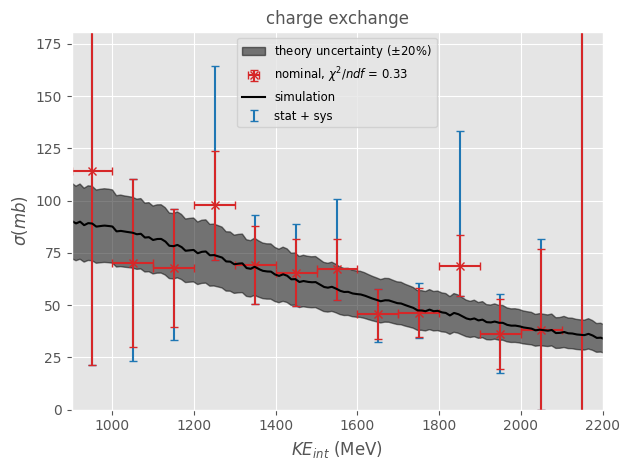

In [62]:
norm_sys = []
for r in results[0]:
    err_low = SysErr(results[1][r][1.2], results[0][r][1.2][0])
    err_high = SysErr(results[1][r][0.8], results[0][r][0.8][0])

    sys_err_low = np.max([err_low[0], err_high[0]], 0)
    sys_err_high = np.max([err_low[1], err_high[1]], 0)

    norm_sys.append([sys_err_low, sys_err_high])

total_norm_sys = cross_section.quadsum(norm_sys, 0)
total_sys = [cross_section.quadsum([xs_nominal[1], total_norm_sys[0]], 0), cross_section.quadsum([xs_nominal[1], total_norm_sys[1]], 0)]

cross_section.PlotXSComparison({"nominal" : xs_nominal}, args.energy_slices, "charge_exchange", {"nominal" : "C6"}, xs_sim_color = "k")
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = total_sys, linestyle = "", marker = "", label = f"stat + sys", newFigure = False, zorder = 1.5)
Plots.plt.fill_between(xs_sim.KE, getattr(xs_sim, args.signal_process) * 0.8, getattr(xs_sim, args.signal_process) * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
Plots.plt.legend()

book.Save()

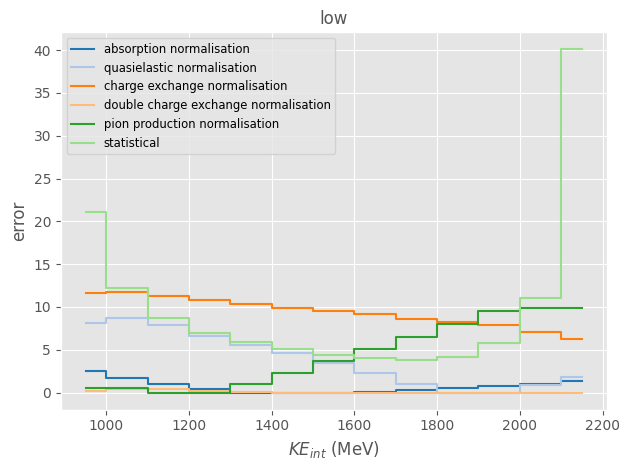

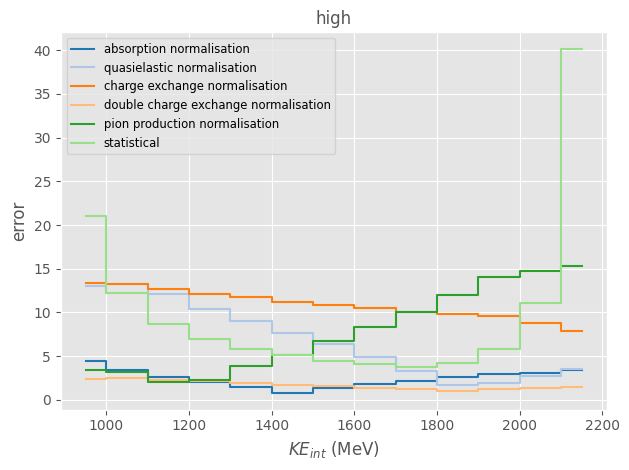

In [26]:
plot = ["low", "high"]
for j in range(2):
    Plots.plt.figure()
    for r, i in zip(results, norm_sys):
        Plots.Plot(args.energy_slices.pos[:-1] - args.energy_slices.width/2, i[j][:-1], label = cross_section.remove_(r) + " normalisation", xlabel = "$KE_{int}$ (MeV)", ylabel = "error", title = plot[j], newFigure = False, style = "step")
    Plots.Plot(args.energy_slices.pos[:-1] - args.energy_slices.width/2, xs_nominal[1][:-1], label = "statistical", xlabel = "$KE_{int}$ (MeV)", ylabel = "error", newFigure = False, style = "step")
    book.Save()

# Plots.plt.figure()
# for r, i in zip(results, norm_sys):
#     Plots.Plot(args.energy_slices.pos[:-1] - args.energy_slices.width/2, i[1][:-1], label = cross_section.remove_(r) + " normalisation", xlabel = "$KE_{int}$ (MeV)", ylabel = "error", title = "high", newFigure = False, style = "step")
# Plots.Plot(args.energy_slices.pos[:-1] - args.energy_slices.width/2, xs_nominal[1][:-1], label = "statistical", xlabel = "$KE_{int}$ (MeV)", ylabel = "error", title = "low", newFigure = False, style = "step")

In [27]:
book.close()

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


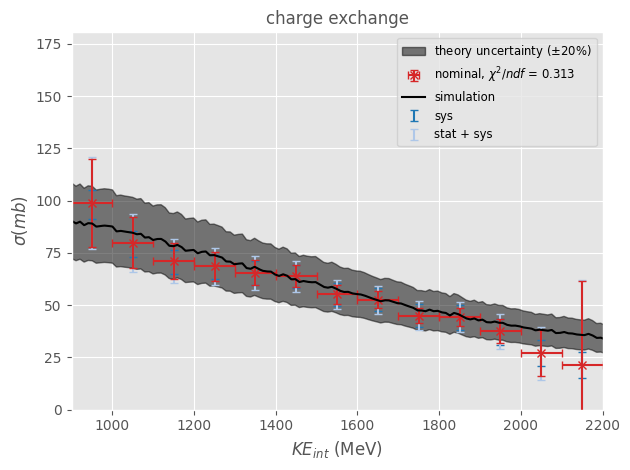

In [33]:
import itertools

def err_cov(norm):
    epsilon_sqr = None
    for r1, r2 in itertools.product(results, results):
        epsilon_1 = results[r1][norm][0] - xs_nominal[0]
        epsilon_2 = results[r2][norm][0] - xs_nominal[0]

        prod = epsilon_1 * epsilon_2

        if epsilon_sqr is None:
            epsilon_sqr = prod
        else:
            epsilon_sqr = epsilon_sqr + prod
    return np.sqrt(epsilon_sqr)

err_cov_total = np.array([err_cov(0.8), err_cov(1.2)])

cross_section.PlotXSComparison({"nominal" : xs_nominal}, args.energy_slices, "charge_exchange", {"nominal" : "C6"}, xs_sim_color = "k")
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = err_cov_total, linestyle = "", marker = "", label = f"sys", newFigure = False, zorder = 1.5)
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = cross_section.quadsum([xs_nominal[1], err_cov_total], 0), linestyle = "", marker = "", label = f"stat + sys", newFigure = False, zorder = 1.5)
Plots.plt.fill_between(xs_sim.KE, getattr(xs_sim, args.signal_process) * 0.8, getattr(xs_sim, args.signal_process) * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
Plots.plt.legend()


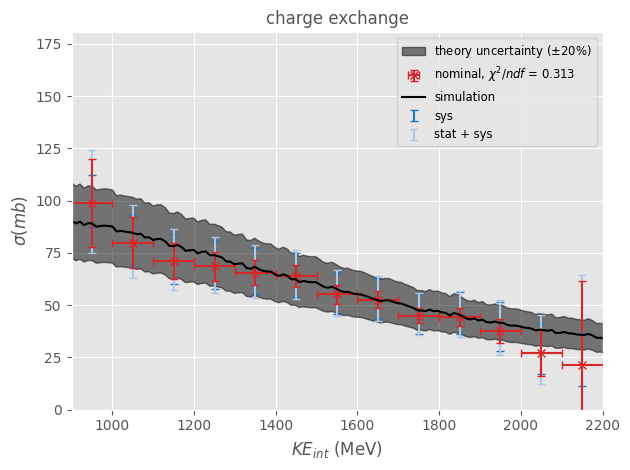

In [34]:
np.max(np.array(norm_sys)[:, 0], 0)
np.max(np.array(norm_sys)[:, 1], 0)

max_err = np.max(np.array(norm_sys), 0)

cross_section.PlotXSComparison({"nominal" : xs_nominal}, args.energy_slices, "charge_exchange", {"nominal" : "C6"}, xs_sim_color = "k")
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = max_err, linestyle = "", marker = "", label = f"sys", newFigure = False, zorder = 1.5)
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = cross_section.quadsum([xs_nominal[1], max_err], 0), linestyle = "", marker = "", label = f"stat + sys", newFigure = False, zorder = 1.5)
Plots.plt.fill_between(xs_sim.KE, getattr(xs_sim, args.signal_process) * 0.8, getattr(xs_sim, args.signal_process) * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
Plots.plt.legend()

(0.0, 20.0)

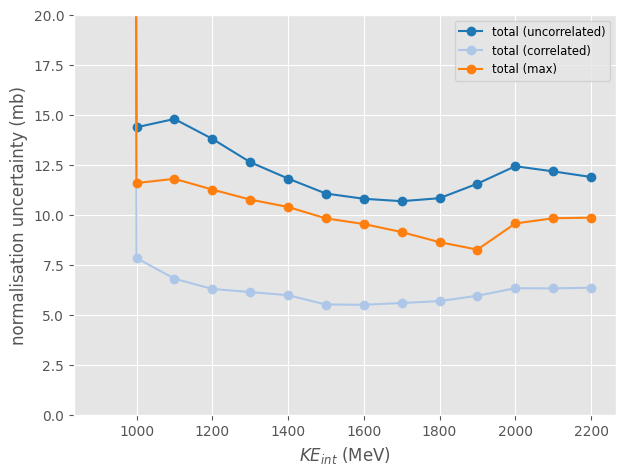

In [37]:
Plots.Plot(args.energy_slices.pos, total_norm_sys[0], label = "total (uncorrelated)", marker = "o")
Plots.Plot(args.energy_slices.pos, err_cov_total[0], label = "total (correlated)", marker = "o", newFigure = False)
Plots.Plot(args.energy_slices.pos, max_err[0], label = "total (max)", xlabel = "$KE_{int}$ (MeV)", ylabel = "normalisation uncertainty (mb)", marker = "o", newFigure = False)
Plots.plt.ylim(0, 20)

## without unfolding

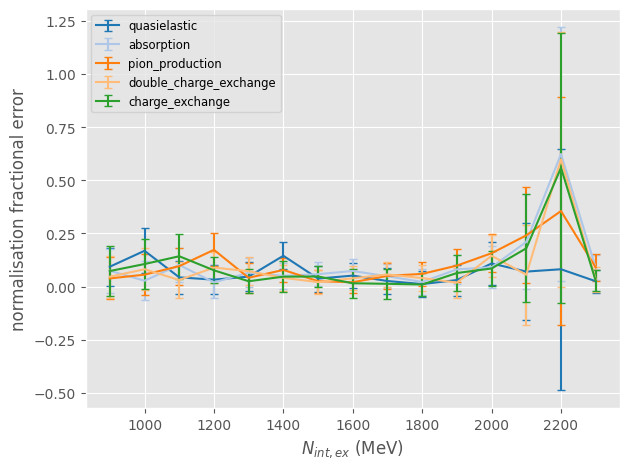

In [30]:
directory = "test/region_fit_studies_2GeV/normalisation_test_normal/"

s_fe_max, b_fe_max, s_fe_total_max, b_fe_total_max = cex_fit_studies.BackgroundSubtractionSummary(directory, model, "charge_exchange", args.toy_template, "normalisation")

for k in s_fe_max:
    Plots.Plot(energy_overflow, s_fe_max[k][0], yerr = s_fe_max[k][1], label = k, ylabel = "normalisation fractional error", xlabel = "$N_{int,ex}$ (MeV)", newFigure = False)
book.Save()

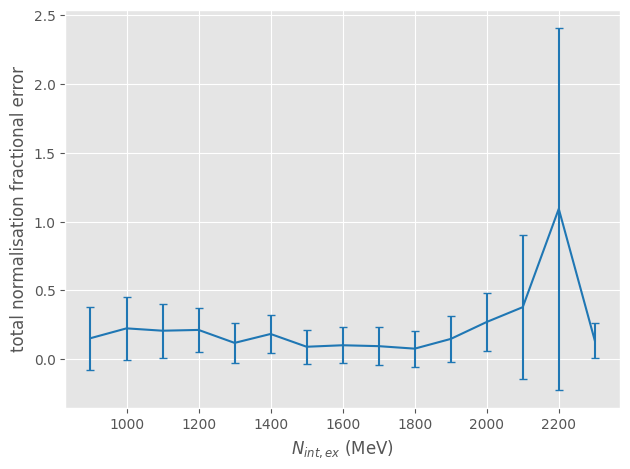

In [31]:
s_fe_sum = cross_section.quadsum([s_fe_max[i][0] for i in s_fe_max], 0)

s_fe_sum_err = cross_section.quadsum([s_fe_max[i][1] for i in s_fe_max], 0)

Plots.Plot(energy_overflow, s_fe_sum, yerr = s_fe_sum_err, ylabel = "total normalisation fractional error", xlabel = "$N_{int,ex}$ (MeV)")
book.Save()

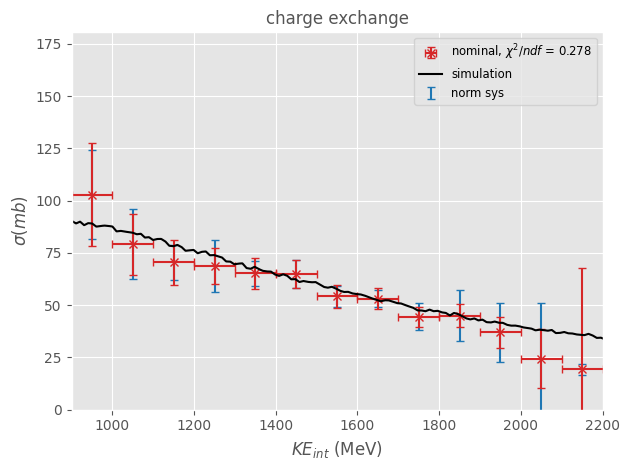

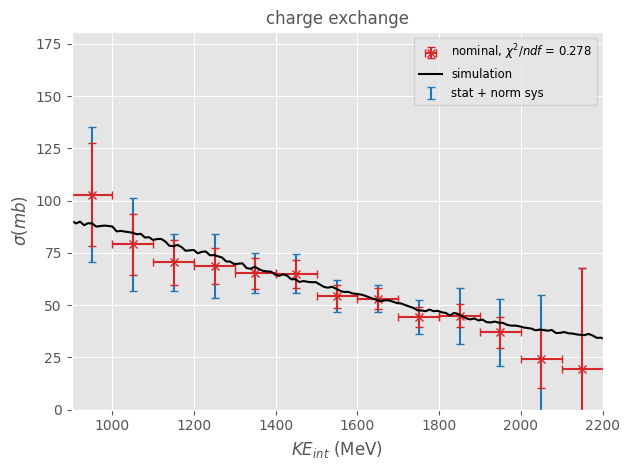

In [39]:
norm_err = abs(s_fe_sum[:-1] * xs_nominal[0])
cross_section.PlotXSComparison({"nominal" : xs_nominal}, args.energy_slices, "charge_exchange", {"nominal" : "C6"}, xs_sim_color = "k")
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = norm_err, linestyle = "", marker = "", label = "norm sys", newFigure = False, zorder = 1)
book.Save()
cross_section.PlotXSComparison({"nominal" : xs_nominal}, args.energy_slices, "charge_exchange", {"nominal" : "C6"}, xs_sim_color = "k")
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = cross_section.quadsum([norm_err, xs_nominal[1]], 0), linestyle = "", marker = "", label = "stat + norm sys", newFigure = False, zorder = 1)
book.Save()

# cross_section.PlotXSComparison({"nominal" : xs_nominal}, args.energy_slices, "charge_exchange", {"nominal" : "C0"}, xs_sim_color = "k")

In [33]:
book.close()

pdf normalisation_sys.pdf has been closed


# Detector parameterisation systematic

In [40]:
def CreateNewAnalysisInput(toy : cross_section.Toy, new_smearing : cross_section.pd.DataFrame):
    new_smeared = cex_toy_generator.ApplySmearing(toy.df, new_smearing)
    analysis_input = cross_section.AnalysisInput.CreateAnalysisInputToy(toy)
    analysis_input.KE_init_reco = new_smeared.KE_init_smeared
    analysis_input.track_length_reco = new_smeared.z_int_smeared
    analysis_input.KE_int_reco = new_smeared.KE_int_smeared
    return analysis_input


In [41]:
smearing_params = {
    "KE_init" : cross_section.LoadConfiguration("/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_init/double_crystal_ball.json"),
    "KE_int" : cross_section.LoadConfiguration("/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int/double_crystal_ball.json"),
    "z_int" : cross_section.LoadConfiguration("/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/z_int/double_crystal_ball.json")
    }

p_high = {}
p_low = {}
for i, j in smearing_params.items():
    p_high[i] = {k : j["values"][k] + j["errors"][k] for k in j["values"]}
    p_low[i] = {k : j["values"][k] - j["errors"][k] for k in j["values"]}

smearing = cross_section.pd.DataFrame({f"{k}_smearing" : cross_section.Fitting.RejectionSampling(len(toy_nominal.df), min(v["range"]), max(v["range"]), getattr(cross_section.Fitting, v["function"]), v["values"], rng = np.random.default_rng(1)) for k, v in smearing_params.items()})
analysis_input_nominal = CreateNewAnalysisInput(toy_nominal, smearing)


model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697481.07954271])


signal: charge_exchange

Iteration 1: ts = 0.0002, ts_stopping = 0.0001
Iteration 2: ts = 0.0001, ts_stopping = 0.0001
Iteration 3: ts = 0.0001, ts_stopping = 0.0001
Iteration 1: ts = 0.0002, ts_stopping = 0.0001
Iteration 2: ts = 0.0001, ts_stopping = 0.0001
Iteration 3: ts = 0.0001, ts_stopping = 0.0001
Iteration 4: ts = 0.0001, ts_stopping = 0.0001
Iteration 5: ts = 0.0001, ts_stopping = 0.0001
Iteration 6: ts = 0.0001, ts_stopping = 0.0001
Iteration 1: ts = 0.0063, ts_stopping = 0.0001
Iteration 2: ts = 0.0028, ts_stopping = 0.0001
Iteration 3: ts = 0.0014, ts_stopping = 0.0001
Iteration 4: ts = 0.0008, ts_stopping = 0.0001
Iteration 5: ts = 0.0009, ts_stopping = 0.0001
Iteration 6: ts = 0.0009, ts_stopping = 0.0001
Iteration 7: ts = 0.0008, ts_stopping = 0.0001
Iteration 8: ts = 0.0007, ts_stopping = 0.0001
Iteration 9: ts = 0.0006, ts_stopping = 0.0001
Iteration 10: ts = 0.0006, ts_stopping = 0.0001


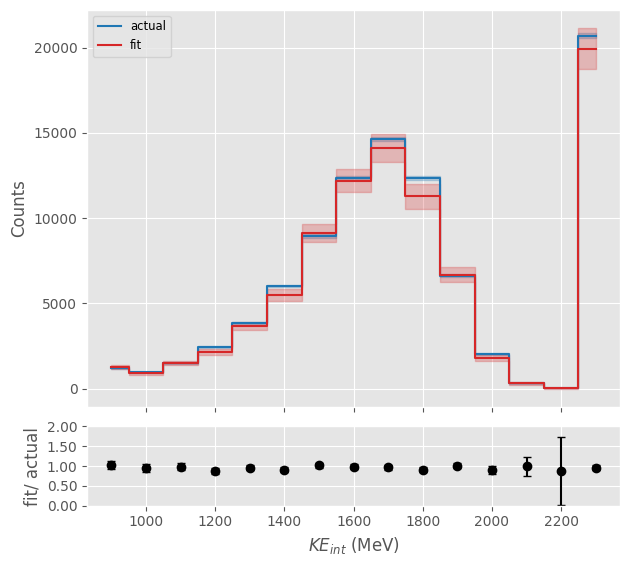

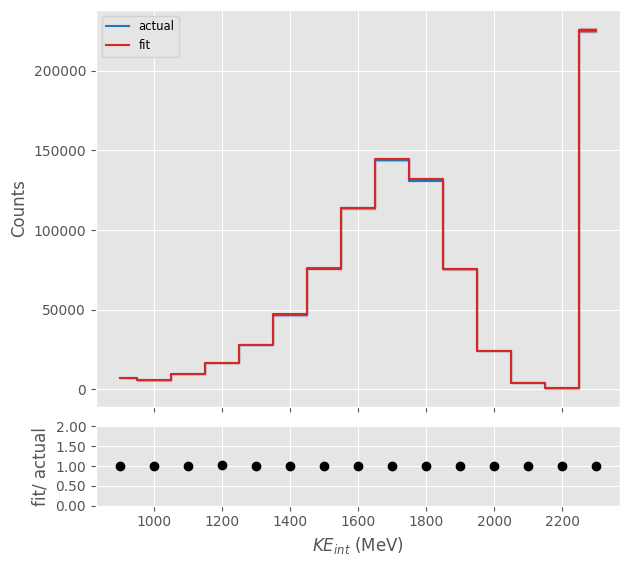

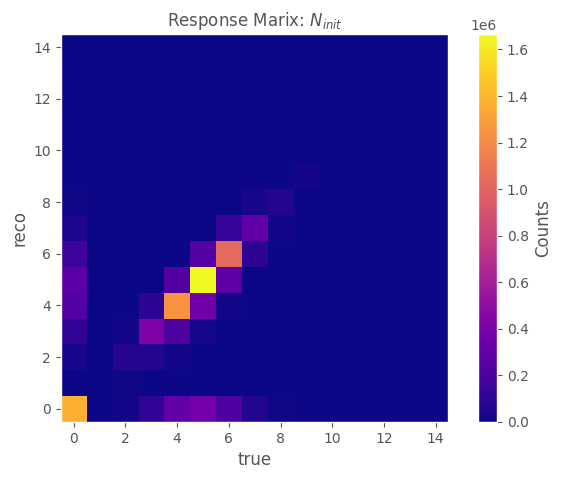

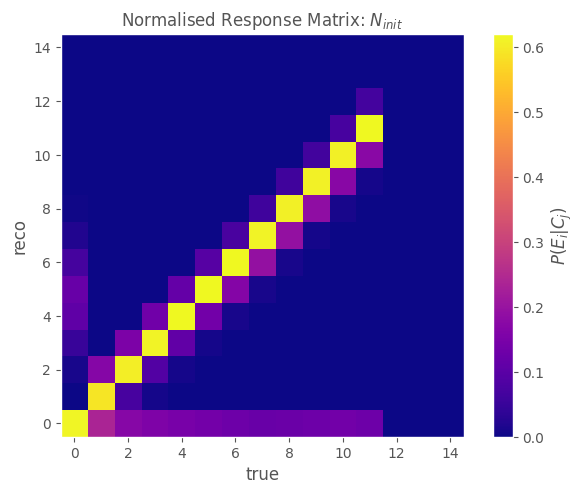

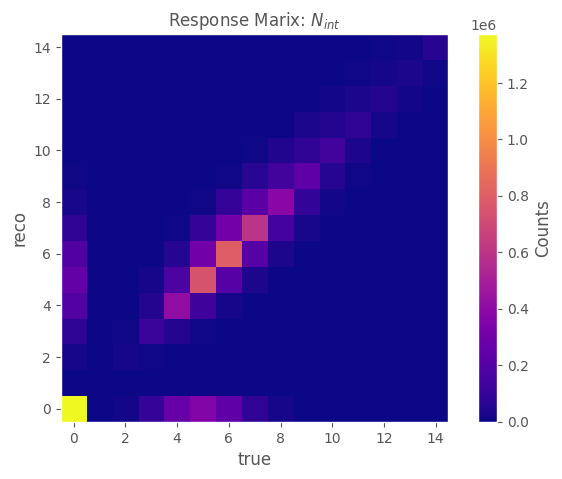

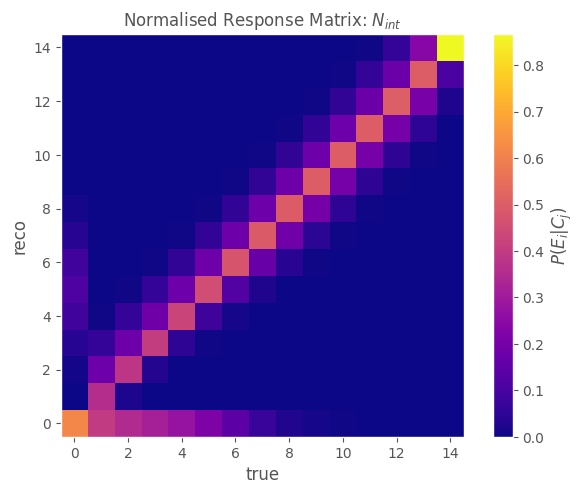

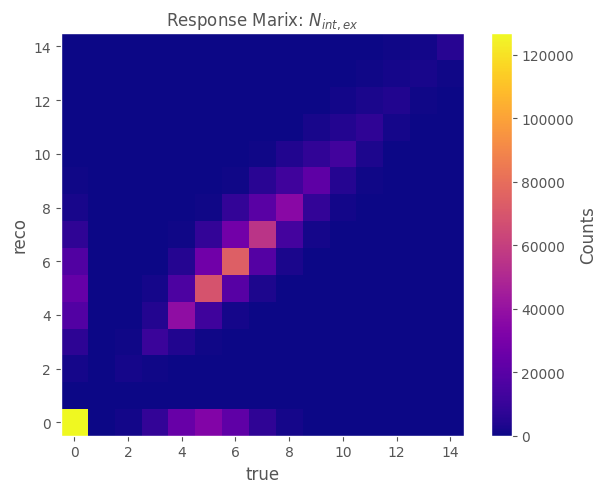

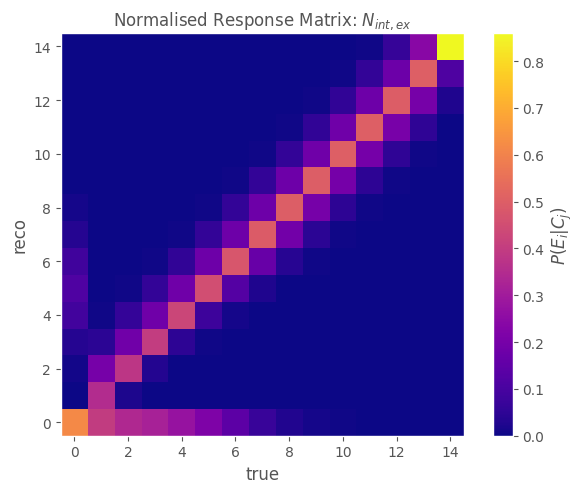

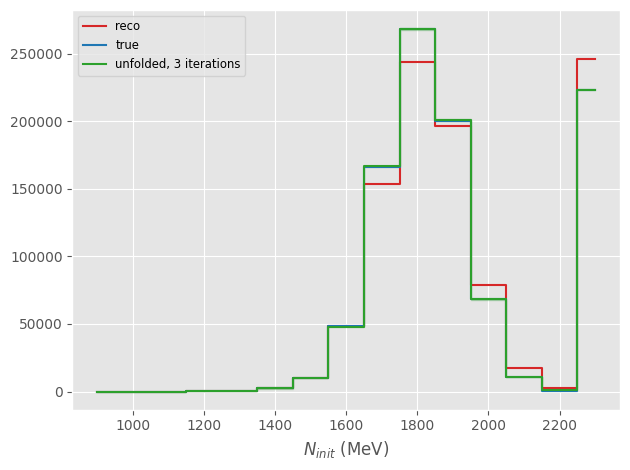

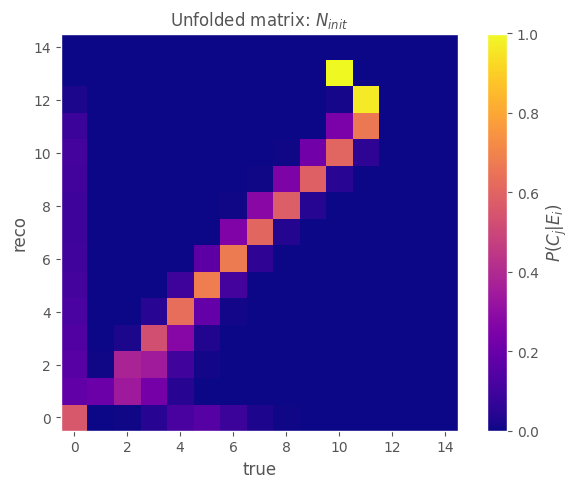

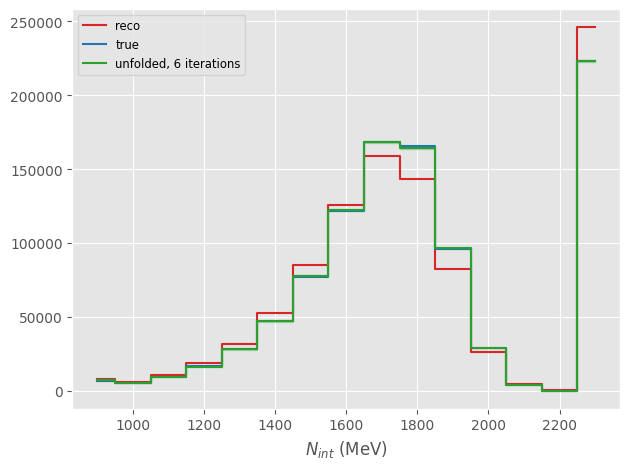

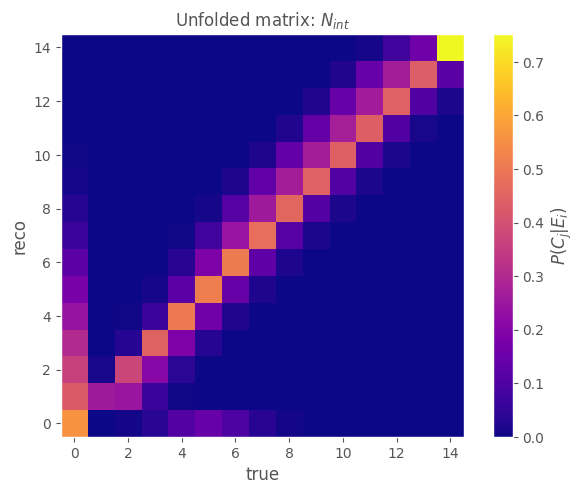

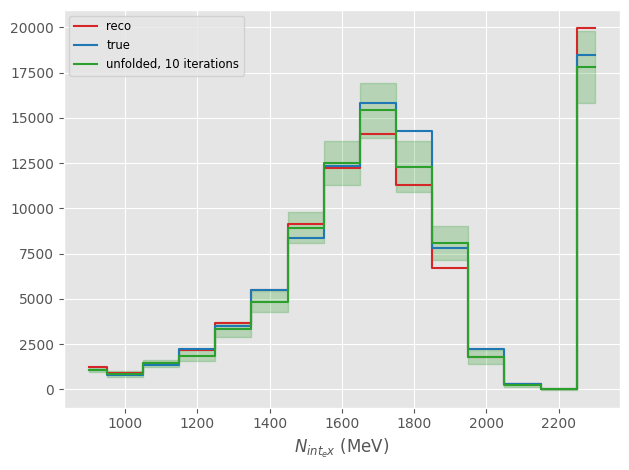

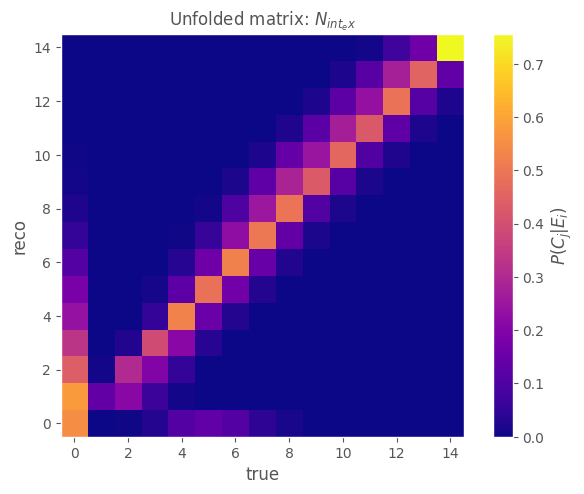

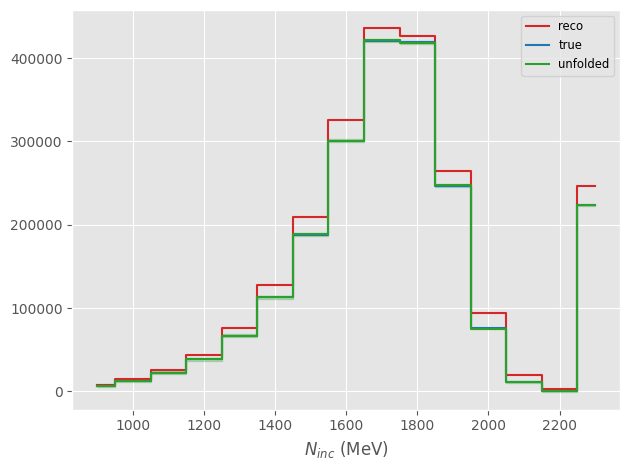

In [42]:
xs_nominal = Analyse(analysis_input_nominal, model, args, args.energy_slices, None)

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697490.2922123])


signal: charge_exchange

Iteration 1: ts = 0.0008, ts_stopping = 0.0001
Iteration 2: ts = 0.0005, ts_stopping = 0.0001
Iteration 3: ts = 0.0003, ts_stopping = 0.0001
Iteration 4: ts = 0.0002, ts_stopping = 0.0001
Iteration 5: ts = 0.0001, ts_stopping = 0.0001
Iteration 6: ts = 0.0001, ts_stopping = 0.0001
Iteration 7: ts = 0.0001, ts_stopping = 0.0001
Iteration 1: ts = 0.0009, ts_stopping = 0.0001
Iteration 2: ts = 0.0003, ts_stopping = 0.0001
Iteration 3: ts = 0.0003, ts_stopping = 0.0001
Iteration 4: ts = 0.0003, ts_stopping = 0.0001
Iteration 5: ts = 0.0002, ts_stopping = 0.0001
Iteration 6: ts = 0.0002, ts_stopping = 0.0001
Iteration 7: ts = 0.0002, ts_stopping = 0.0001
Iteration 8: ts = 0.0002, ts_stopping = 0.0001
Iteration 9: ts = 0.0001, ts_stopping = 0.0001
Iteration 10: ts = 0.0001, ts_stopping = 0.0001
Iteration 1: ts = 0.0036, ts_stopping = 0.0001
Iteration 2: ts = 0.0036, ts_stopping = 0.0001
Iteration 3: ts = 0.0033, ts_stopping = 0.0001
Iteration 4: ts = 0.0029, ts_stopping = 0.0001
Iteration 5:

signal: charge_exchange

Iteration 1: ts = 0.0007, ts_stopping = 0.0001
Iteration 2: ts = 0.0005, ts_stopping = 0.0001
Iteration 3: ts = 0.0004, ts_stopping = 0.0001
Iteration 4: ts = 0.0003, ts_stopping = 0.0001
Iteration 5: ts = 0.0002, ts_stopping = 0.0001
Iteration 6: ts = 0.0002, ts_stopping = 0.0001
Iteration 7: ts = 0.0001, ts_stopping = 0.0001
Iteration 8: ts = 0.0001, ts_stopping = 0.0001
Iteration 9: ts = 0.0001, ts_stopping = 0.0001
Iteration 1: ts = 0.0015, ts_stopping = 0.0001
Iteration 2: ts = 0.0004, ts_stopping = 0.0001
Iteration 3: ts = 0.0004, ts_stopping = 0.0001
Iteration 4: ts = 0.0004, ts_stopping = 0.0001
Iteration 5: ts = 0.0003, ts_stopping = 0.0001
Iteration 6: ts = 0.0003, ts_stopping = 0.0001
Iteration 7: ts = 0.0003, ts_stopping = 0.0001
Iteration 8: ts = 0.0002, ts_stopping = 0.0001
Iteration 9: ts = 0.0002, ts_stopping = 0.0001
Iteration 10: ts = 0.0002, ts_stopping = 0.0001
Iteration 1: ts = 0.0138, ts_stopping = 0.0001
Iteration 2: ts = 0.0041, ts_stopping = 0.0001
Iteration 3:

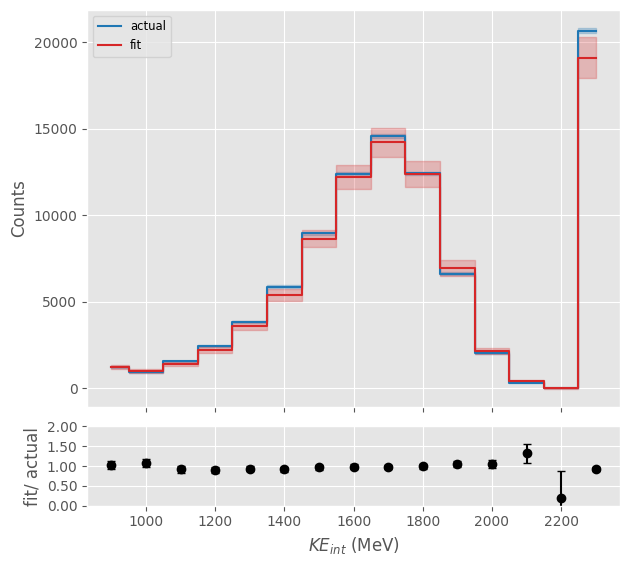

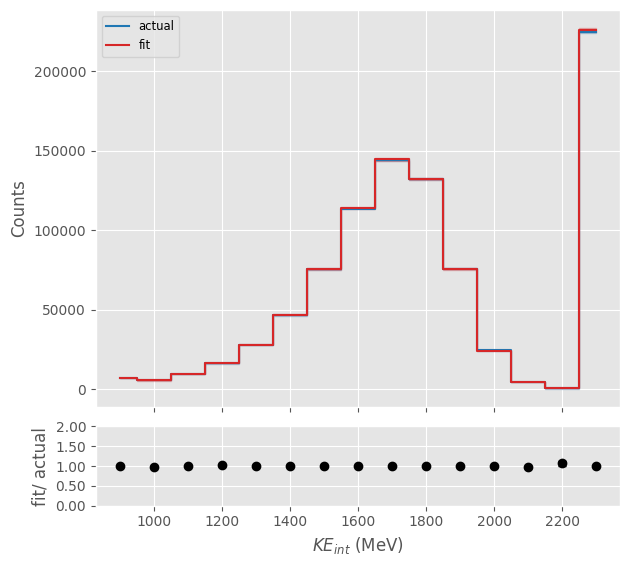

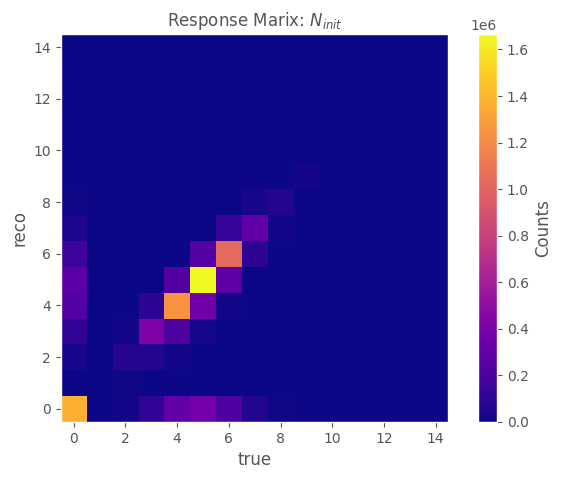

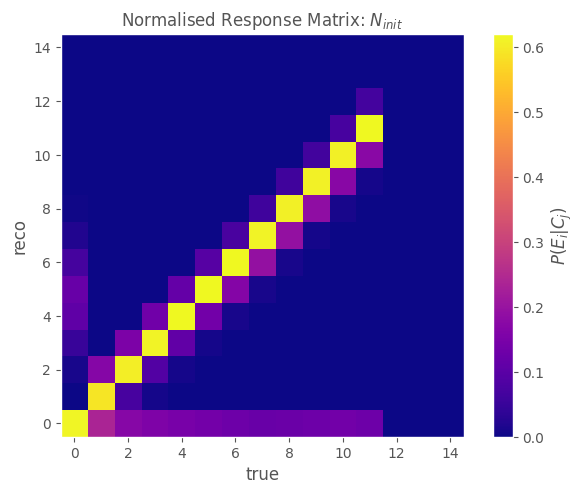

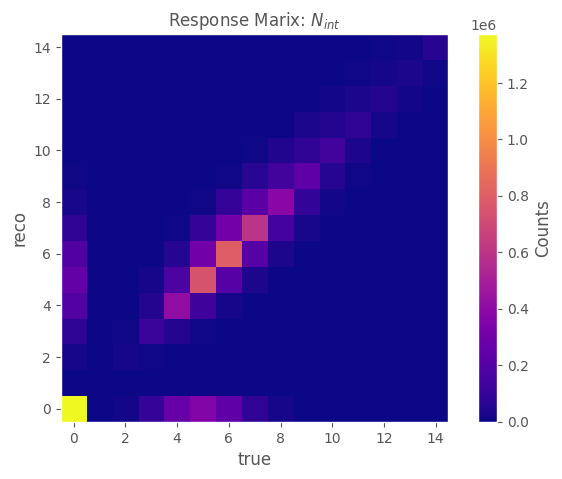

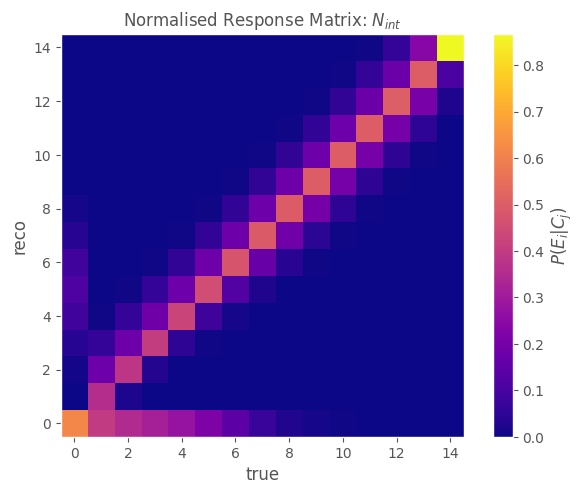

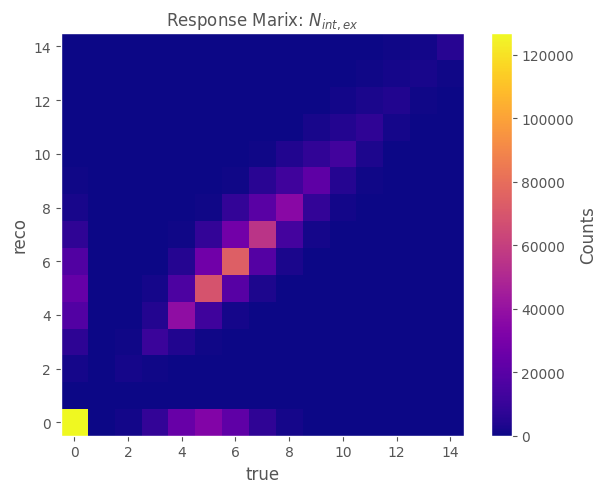

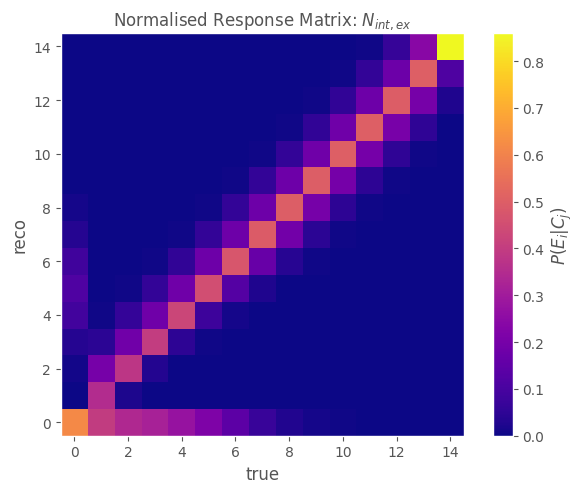

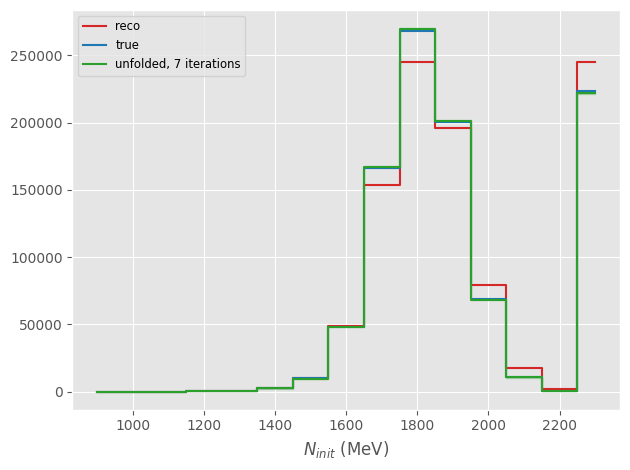

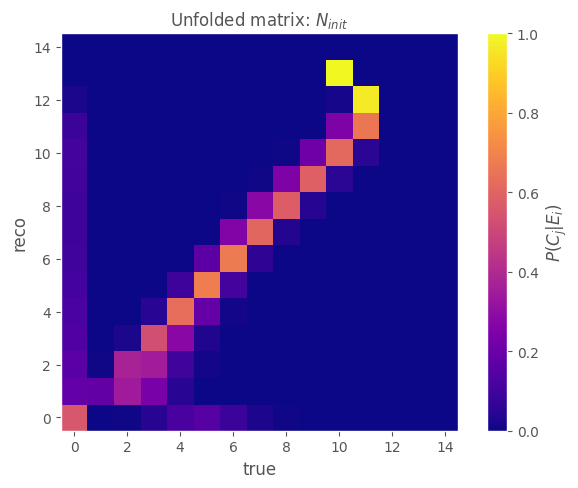

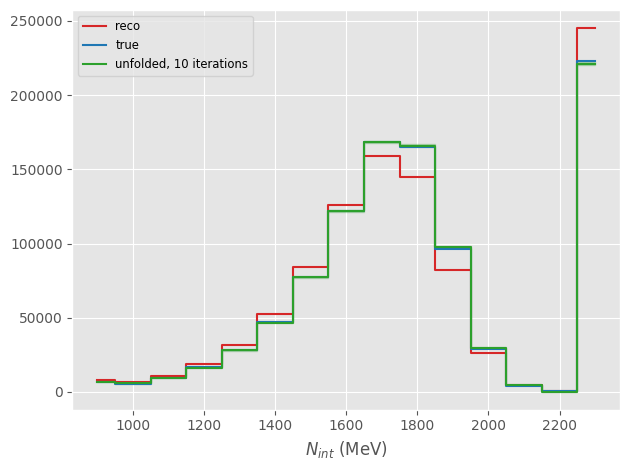

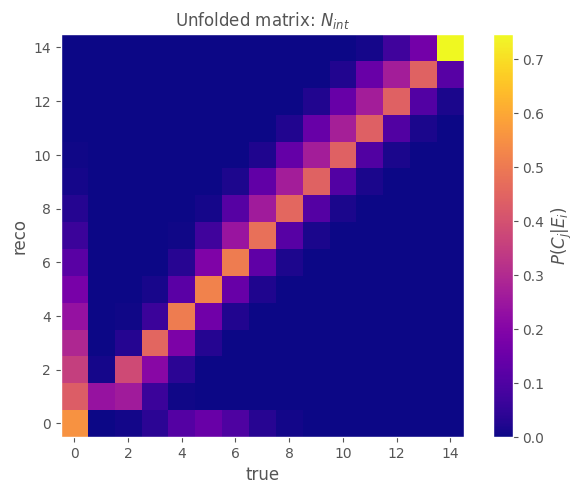

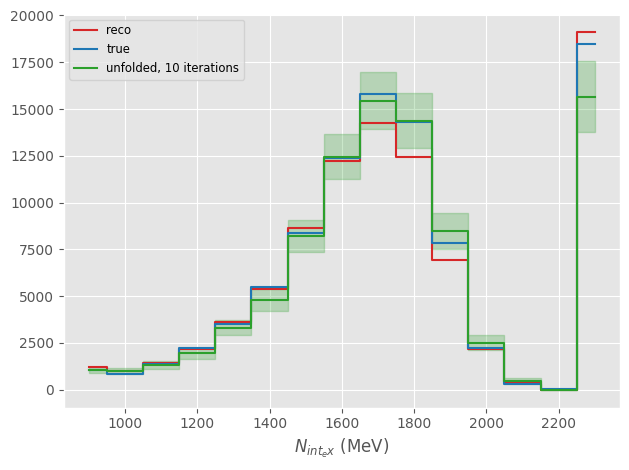

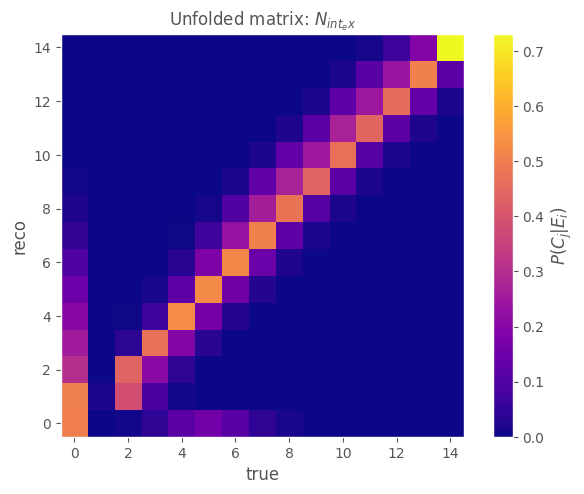

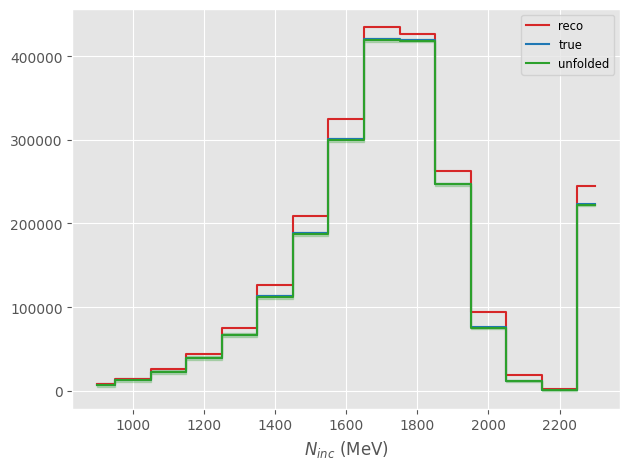

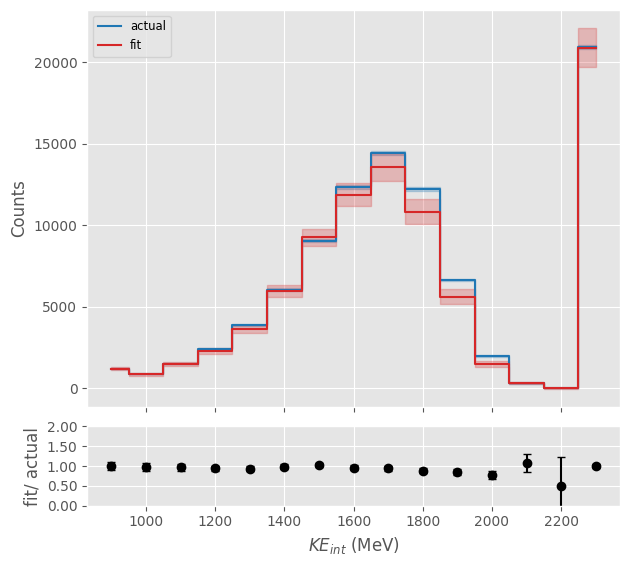

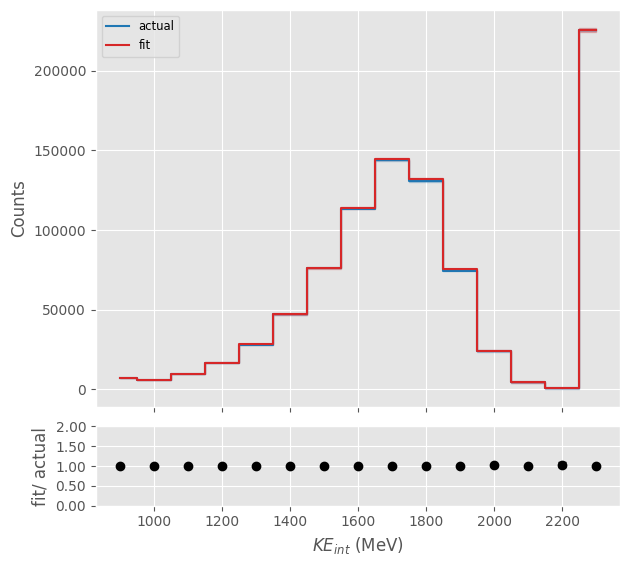

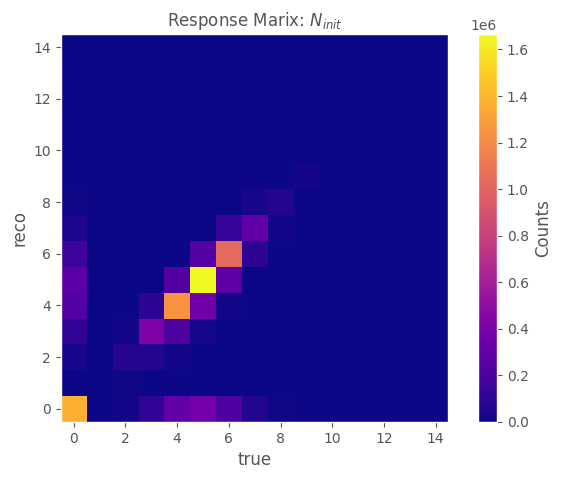

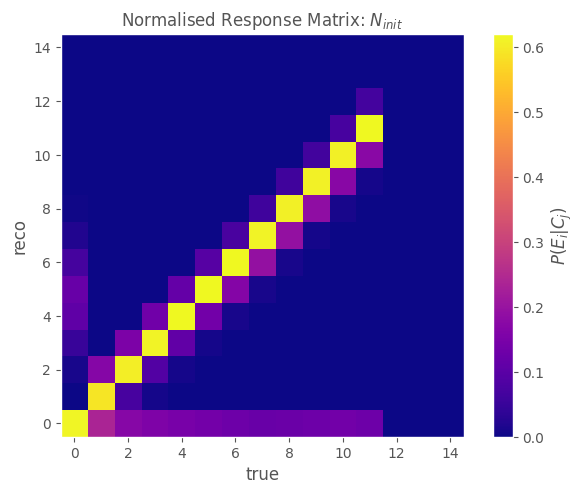

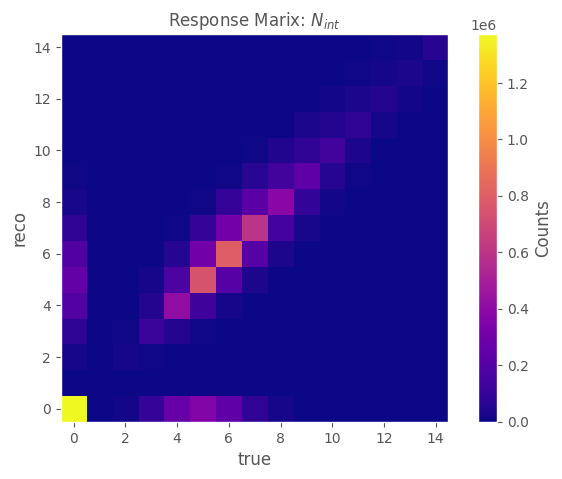

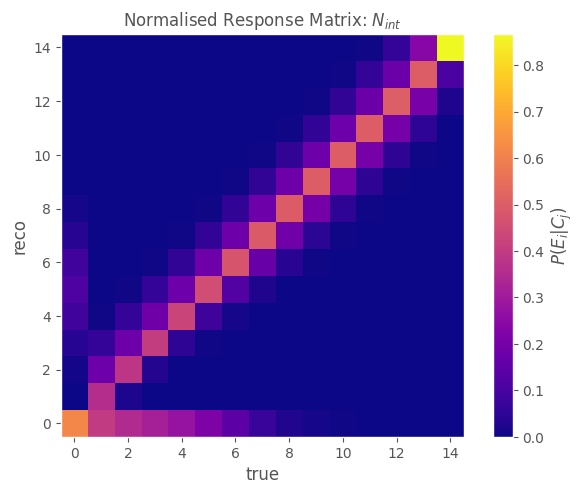

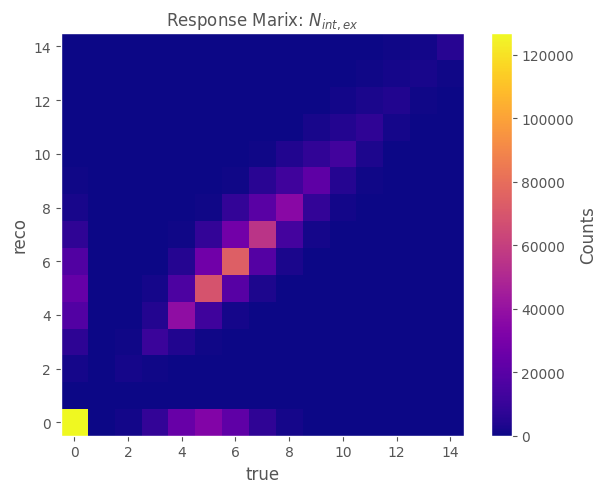

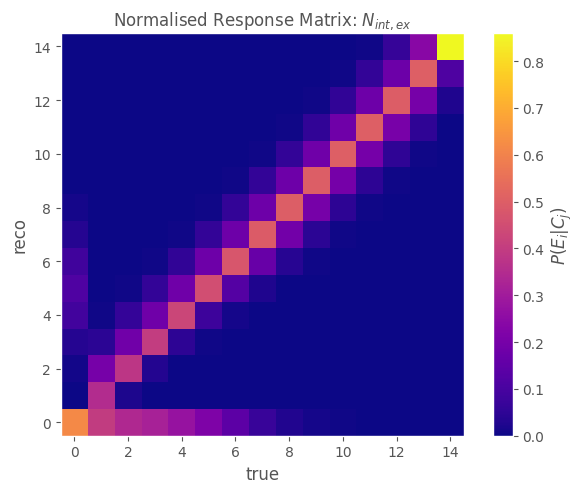

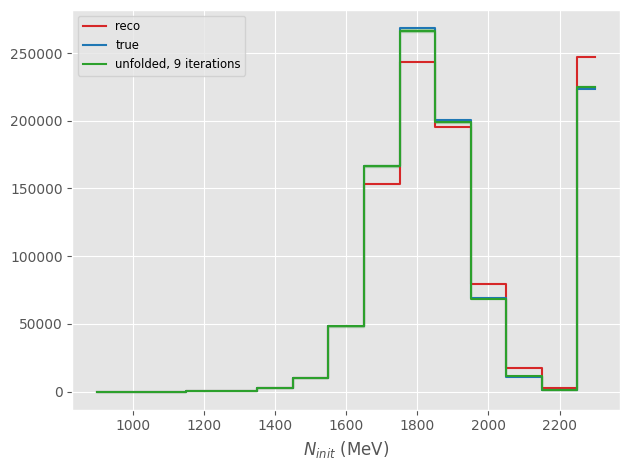

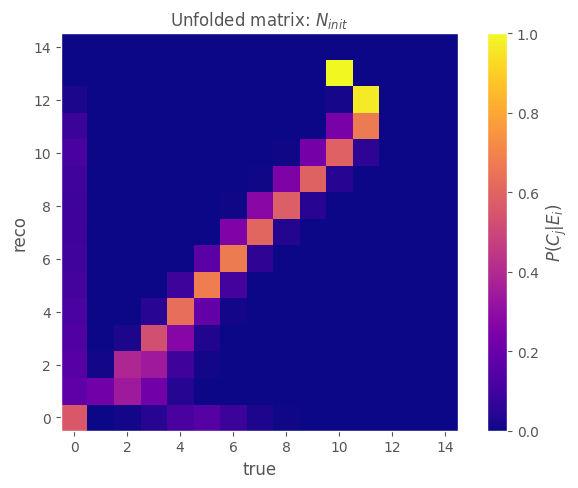

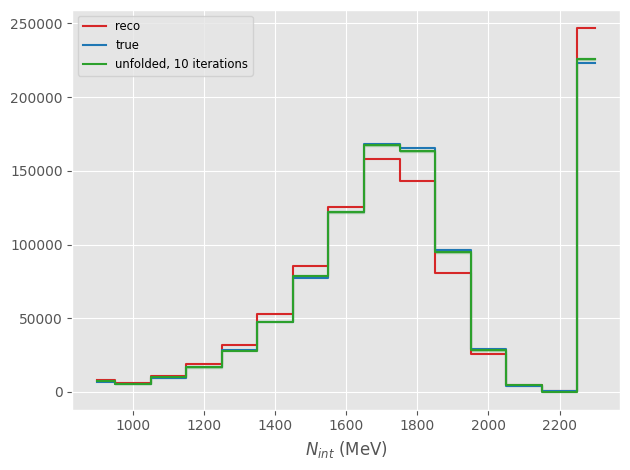

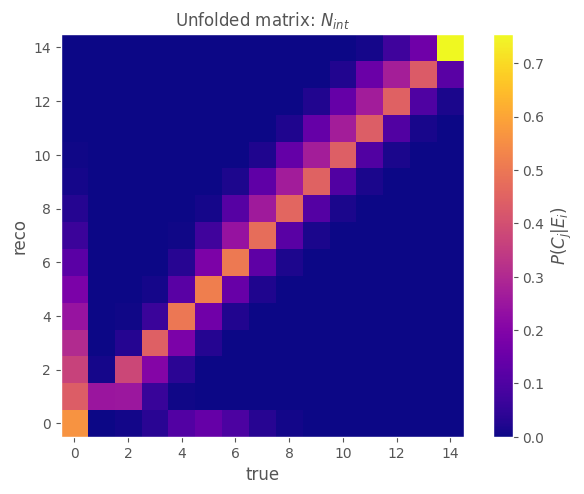

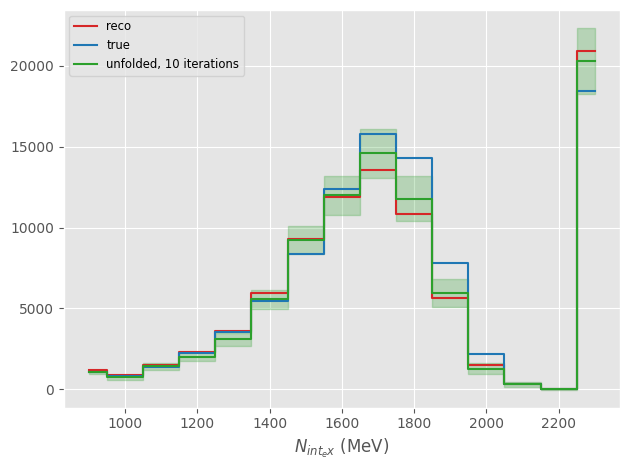

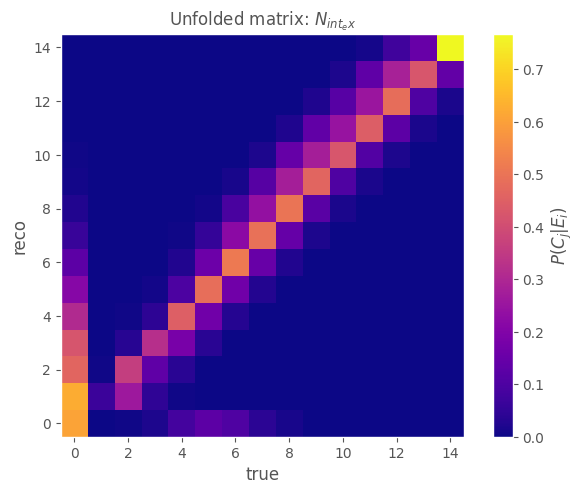

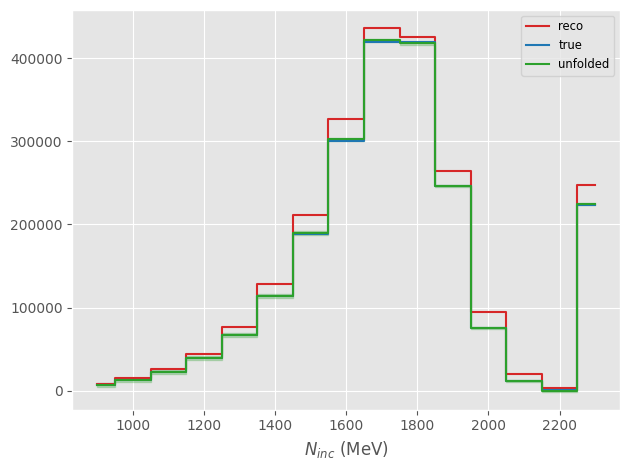

In [43]:
smearing_high = cross_section.pd.DataFrame({f"{k}_smearing" : cross_section.Fitting.RejectionSampling(len(toy_nominal.df), min(v["range"]), max(v["range"]), getattr(cross_section.Fitting, v["function"]), p_high[k], rng = np.random.default_rng(1)) for k, v in smearing_params.items()})
smearing_low = cross_section.pd.DataFrame({f"{k}_smearing" : cross_section.Fitting.RejectionSampling(len(toy_nominal.df), min(v["range"]), max(v["range"]), getattr(cross_section.Fitting, v["function"]), p_low[k], rng = np.random.default_rng(1)) for k, v in smearing_params.items()})
analysis_input_high = CreateNewAnalysisInput(toy_nominal, smearing_high)
analysis_input_low = CreateNewAnalysisInput(toy_nominal, smearing_low)

xs_high = Analyse(analysis_input_high, model, args, args.energy_slices, None)
xs_low = Analyse(analysis_input_low, model, args, args.energy_slices, None)

In [44]:
book = Plots.PlotBook("detector_sys_5E6.pdf", False)

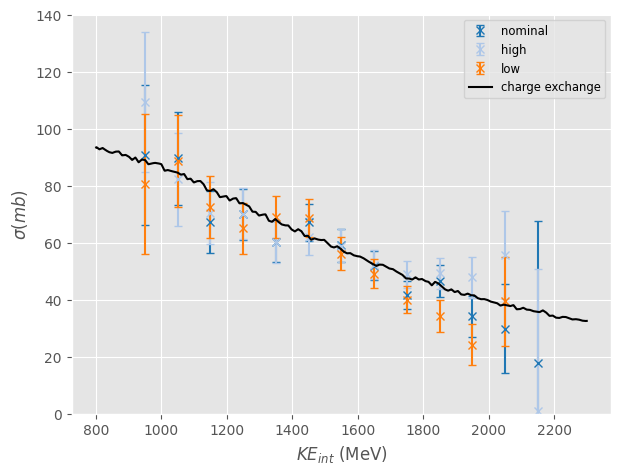

In [45]:
geant_xs = cross_section.GeantCrossSections(energy_range = [args.energy_slices.min_pos - args.energy_slices.width, args.energy_slices.max_pos + args.energy_slices.width])

Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = xs_nominal[1], linestyle = "", marker = "x", label = "nominal")
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_high[0], yerr = xs_nominal[1], linestyle = "", marker = "x", label = "high", newFigure = False)
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_low[0], yerr = xs_nominal[1], linestyle = "", marker = "x", label = "low", newFigure = False)
geant_xs.Plot("charge_exchange", color = "k")

Plots.plt.ylim(0, 1.5 * max(getattr(geant_xs, "charge_exchange")))

book.Save()

(
    array([ 0.        ,  0.        , 10.02803284, 12.38589057,  1.70268539,
        2.89292147,  2.84414743,  0.        ,  0.        ,  4.92595399,
        0.        ,  0.91869747, 10.1797197 ,  0.        ]),
    array([0.        , 9.57268829, 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.54099236, 8.62814821, 0.        ,
       5.35825788, 0.        , 0.        , 0.        ])
)

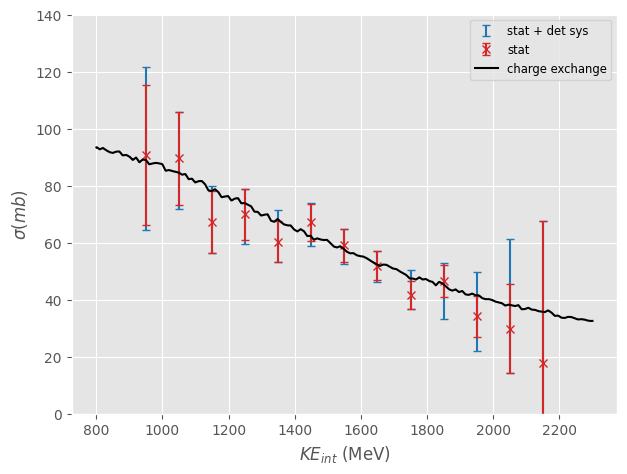

In [47]:
def quadsum(*arg):
    return np.sqrt(sum([a**2 for a in arg]))

err_high_var = SysErr(xs_nominal[0], xs_high[0])
err_low_var = SysErr(xs_nominal[0], xs_low[0])

sys_err_low = quadsum(err_low_var[0], err_high_var[0])
sys_err_high = quadsum(err_low_var[1], err_high_var[1])

print(err_low_var)

total_err_low = quadsum(xs_nominal[1], sys_err_low)
total_err_high = quadsum(xs_nominal[1], sys_err_high)

Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = (total_err_low, total_err_high), linestyle = "", marker = "", label = "stat + det sys", newFigure = False)
# Plots.Plot(energy_slices.pos - energy_slices.width/2, xs_nominal[0], yerr = (sys_err_low, sys_err_high), linestyle = "", marker = "", label = "sys", newFigure = False)
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = xs_nominal[1], linestyle = "", marker = "x", label = "stat", color = "C6", newFigure = False)
geant_xs.Plot("charge_exchange", "k")
Plots.plt.ylim(0, 1.5 * max(getattr(geant_xs, "charge_exchange")))

book.Save()
book.close()